**Author**: JW Debelius (justine.debelius@jhu.edu)<br>
**Creation Date**: November 2022<br>
**Update**: November 2024; July 2023; March 2023, 14 December 2022<br>
<!-- **Enviroment**: python 3.8 (`qiime2-2022.2` conda based) -->

In [1]:
import copy
from functools import partial
import itertools as it

# Data handling
import numpy as np
import pandas as pd
from numpy.random import choice
from numpy.linalg import LinAlgError

# Statistical tests
import statsmodels.formula.api as smf
import statsmodels.api as sms
import patsy
import scipy
from scipy.stats import t as t_dist

# Displaying my data
from matplotlib import rcParams
import matplotlib.colors as mpc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
import seaborn as sn

# import ptitprince as pt


# Simulation data
import scripts.bw_sim as bw_sim
import scripts.bw_ana as bw_ana
import scripts.sim_example_plots as sexp
import scripts.example_plots as exp_plots

rcParams['text.usetex'] = True


from IPython.display import HTML

In [2]:
%matplotlib inline

In [3]:
np.random.seed(1899)

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import (ConvergenceWarning,
                                             IterationLimitWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=IterationLimitWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Simulation Set Up

## Simulation Parameters

### Demographics

We're interested in 3 categorical demographic confounders. For each of these, we'll build a set of cohort distribution seeds that can be drawn for each simulation 

#### Race

Race is a 4 level covariant with 5 potential seed distributions

| Seed set | Seed probability     | 0     | 1      | 2     | 3     |
| ------   | ----- | ----- | ------ | ----- | ----- |
| Seed 1   | 1 / 6 | 40.0% | 30.0%  | 20.0% | 10.0% |
| Seed 2   | 1 / 6 | 50.0% | 50.0%  |  0.0% |  0.0% |
| Seed 3   | 1 / 6 | 33.3% | 66.7%  |  0.0% |  0.0% |
| Seed 4   | 1 / 6 | 14.3% | 14.3%  | 57.1% | 14.3% |
| Seed 5   | 1 / 6 | 70.0% | 10.0%  | 10.0% | 10.0% |
| Seed 6   | 1 / 6 |  0.0% | 100.0% |  0.0% |  0.0% | 

In [5]:
race_seeds = [
    partial(choice, p=np.array([4, 3, 2, 1]) / 10, a=np.arange(4), replace=True),
    partial(choice, p=np.array([5, 5, 0, 0]) / 10, a=np.arange(4), replace=True),
    partial(choice, p=np.array([1, 2, 0, 0]) / 3, a=np.arange(4), replace=True),
    partial(choice, p=np.array([1, 1, 4, 1]) / 7, a=np.arange(4), replace=True),
    partial(choice, p=np.array([7, 1, 1, 1]) / 10, a=np.arange(4), replace=True),
    partial(choice, p=np.array([0, 1, 0, 0]), a=np.arange(4), replace=True),
    partial(choice, p=np.array([0, 0, 0, 1]), a=np.arange(4), replace=True),
    ]
race_weights = np.hstack([np.ones(len(race_seeds) - 1), 0])
race_weights = race_weights / race_weights.sum()

#### Ethnicity

Ethnicity is a 2 level covariant, and we have 5 distributions

| Seed set | Seed probability |   0    |   1    |
| -------- | ---------------- | ------ | ------ |
| Set 1    | 1 / 5            |  80.0% | 20.0%  |
| Set 2    | 1 / 5            | 100.0% |  0.0%  |
| Set 3    | 1 / 5            |   0.0% | 100.0% |
| Set 4    | 1 / 5            |  50.0% |  50.0% |
| Set 5    | 1 / 5            |  80.0% |  20.0% |

In [6]:
eth_seeds = [
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.8, 0.2])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([1.0, 0.0])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.0, 1.0])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.5, 0.5])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.2, 0.8])),
]
eth_weights = np.ones(len(eth_seeds)) / len(eth_seeds)


#### Sex 

Sex is a 2 level categorical covariant. 

| Set seed | Seed Probability |    0   |    1   |
| -------- | ---------------- | ------ | ------ | 
| Balanced | 17 / 20          |  50.0% |  50.0% |
| Girls    |  1 / 20          | 100.0% |   0.0% |
| Boys     |  1 / 20          |   0.0% | 100.0% |
| Sex linked risk |  1 / 20          |  20.0% |  80.0% |

In [7]:
sex_seeds = [
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.5, 0.5])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([1.0, 0.0])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.0, 1.0])),
    partial(choice, a=np.arange(2), replace=True, p=np.array([0.2, 0.8])),
]
sex_weights = np.array([0.85, 0.05, 0.05, 0.05])

#### Maternal Age

The maternal age is continuous and normally distributed, bounded between 18 and 42 years of age. (This is 2 standard deviations for a mean of 30 and a standard deviation of 5 years, which closely corresponds to the underlying ECHO data.) For this we set up 4 seeds: 

| Set Seed | Seed Probability | mean | std | limits   | 
| -------- | ---------------- | ---- | --- | -------- | 
| General  | 6 / 10           |  30  |  5  | (18, 42) | 
| Young    | 1 / 10           |  24  |  3  | (18, 30) |
| Low risk | 1 / 10           |  27  |  5  | (18, 35) |
| Older    | 2 / 10           |  37  |  3  | (35, 42) |

In [8]:
def sim_normal(mean, std, size, cut_lo=18, cut_hi=42):
    """
    Simulates a normal distribution
    """
    dist1 = np.round(np.random.normal(size=size) * std, 0)
    dist2 = np.round(np.random.normal(size=size) * std, 0)
    dist = dist1 + mean
    dist[dist < cut_lo] = dist2[dist < cut_lo] + mean
    dist[dist > cut_hi] = dist2[dist > cut_hi] + mean
    dist[dist < cut_lo] = cut_lo
    dist[dist > cut_hi] = cut_hi
    
    return dist.astype(int)
mage_seeds = [
    partial(sim_normal, mean=30, std=5, cut_lo=18, cut_hi=42),
    partial(sim_normal, mean=24, std=3, cut_lo=18, cut_hi=30),
    partial(sim_normal, mean=27, std=5, cut_lo=18, cut_hi=35),
    partial(sim_normal, mean=38, std=2, cut_lo=35, cut_hi=42),
    ]
mage_weights = np.array([6, 1, 1, 2]) / 10

#### Cohort duration

The overall study is assumed to have been conducted over the course of 20 years. For this, we dont assume any duration time and instead simulate a random starting seed between 0 and 18 years (uniform) and then a duration, starting from a random normal distribution of 5 years (3 year variation), although all studies end at year 20.

In [9]:
def build_years():
    """
    A simple function to randomly simulate a year range
    """
    start_ = np.floor(np.random.uniform(low=0, high=18, size=1))
    dur_ = np.round(np.absolute(np.random.normal(1) * 3 + 5), 0)
    dur_ = max(min((20 - start_), dur_), 3)
    
    return {'min_': start_[0], 'max_': (start_ + dur_)[0]}

In [10]:
def sim_uniform(min_, max_, size, cut_lo=0, cut_hi=20):
    """
    Simulates a unifrom distribution with integer values
    """
    dist = np.random.uniform(min_, max_, size=size)
    dist2 = np.round(np.random.uniform(min_, max_, size=size), 0)
    dist = np.round(dist, 0)
    dist[dist < cut_lo] = dist2[dist < cut_lo]
    dist[dist > cut_hi] = dist2[dist > cut_hi]
    dist[dist < cut_lo] = cut_lo
    dist[dist > cut_hi] = cut_hi
    
    return dist.astype(int)

### Outcome Enrichment and Cohort Selection

For a set of simulations, we'll simulate two cohort types, which are proxies for the ECHO general and NICU cohorts, or let us approximate outcome enriched cohorts. We'll assume that the outcome enrichment

In [11]:
out_types = [0, 1]
out_weights = [0.8, 0.2]

In [12]:
HTML(pd.DataFrame(data={'cohort weight': out_weights},
                  index=pd.Index(out_types, name='cohort type')
                  ).to_html())

,cohort weight
cohort type,
0,0.8
1,0.2


### Cohort Size

For the sizes, we assume that if the cohorts are uniform, we'll return a cohort of ~250 participants.

For non-uniform cohorts, we simulate the probability that a cohort is of small, medium or large size based on seed probabilities for the cohort size; use this to select a number of trials for a anegative binomial distribution, draw the p-value from a normal distribution, and then use that negative binomial to simulate a sample size.

In [13]:
def uniform_sizes(n_cohorts, size=250):
    """
    Generates cohort sizes for uniform cohorts
    """
    print('uniform sizes')
    sizes = np.ones((n_cohorts,), dtype=int) * size
    for s in sizes:
        yield s


def vary_sizes(n_cohorts, p_low=0.1, p_hi=0.20):
    """
    Generates cohort sizes based on a random distribution
    """
    print('vary sizes')
    # Cohort size (low, medium or large)
    n_seeds = np.random.multinomial(
        n=1, pvals=np.array([p_low, 1-(p_low + p_hi), p_hi]), 
        size=n_cohorts) * np.array([0, 1, 4])
    # Scales the cohort size factor for the different cohort sizes
    n_seeds = np.sum(n_seeds, axis=1) *  90 + 10 + \
        30 * (np.sum(n_seeds, axis=1) > 1)
    # Simulates the cohort-specific probaility 
    p = np.absolute(np.random.normal(size=n_cohorts) * 0.1) + 0.2

    # Draws the samples using a negative binomal
    sizes = np.random.negative_binomial(n=n_seeds, p=p, size=n_cohorts)
    sizes = np.round(sizes, 0)

    return sizes

### Exposure Type

We'll set up four potential scenarios for exposure: a population-based rate, no exposed, 50% exposed and all exposed. Within the selection, we'll try to get 5% of cohorts as either totally exposed or totally unexposed.

In [14]:
exposure_group = np.arange(4)
exposure_weight = np.array([17, 1, 1, 1]) / 20

exposure_prob = np.array([0, 1, 2, 3])

And then we set up factors to modify the population-specific probability, leading to confounding. 

We calculate the smoking probability as 

$$
p_{indv} = p_{pop}(1 + \sum{\beta_{i}x_{i}})
$$

In [15]:
smoking_effect = pd.Series({
     'C(race)[T.1]': 0.15,
     'C(race)[T.2]': -0.05,
     'C(race)[T.3]': 0.15,
     'C(ethnicity)[T.1]': -0.3,
     'year': -0.005,
     'm_age': 0.01
})
HTML(smoking_effect.to_frame().to_html())

,0
C(race)[T.1],0.150
C(race)[T.2],-0.050
C(race)[T.3],0.150
C(ethnicity)[T.1],-0.300
year,-0.005
m_age,0.010


### Outcome Simulation

#### Confounders

For the outcome, we'll start with a set of confounders. These are coded based on the way the python code expands the covariates, which is why the levels here are slightly different than other places.

In [16]:
slopes = pd.Series({
    'Intercept': 0,
    'C(sex)[T.1]': 0.5,
     'C(race)[T.1]': -2,
     'C(race)[T.2]': -2,
     'C(race)[T.3]': 1,
     'C(ethnicity)[T.1]': -0.25,
     'year': -0.025,
     'm_age': 0.025,
})
HTML(slopes.to_frame().rename(columns={0: '$\\beta$'}).to_html())

,$\beta$
Intercept,0.000
C(sex)[T.1],0.500
C(race)[T.1],-2.000
C(race)[T.2],-2.000
C(race)[T.3],1.000
C(ethnicity)[T.1],-0.250
year,-0.025
m_age,0.025


#### Exposure Effect

I want the potential for a small and large effect size, which might modify the effect

In [17]:
effects = np.array([-0.1, -0.5])
print('Effect sizes:', ', '.join(effects.astype(str)))

Effect sizes: -0.1, -0.5


#### Cohort Type

I want to have an option where we either have a consistent slope by cohort type, where the NICU children are low birth weight (in this case, 2 standard deviations lower than the general cohorts). We'll code general cohorts as "0" and preterm as "1"

In [18]:
type_slope = {0: 0, 1: -3}
HTML(pd.Series(type_slope, name='effect').to_frame().to_html())

,effect
0,0
1,-3


We'll also define a palette to help identify the cohort type.

In [19]:
cohort_type_palette = {0: mpc.to_hex(sn.color_palette(n_colors=2)[1]),
                       1: mpc.to_hex(sn.color_palette(n_colors=2)[0]),
                      }

#### Cohort Error

To be able to have an interclass correlation, we add a random  error term for the cohort, representing a random intercept, which has a mean of 0 and a variance term, $\sigma^{2}_{cohort}$, which is related to the ICC estimated for the data. I want to set the possible ICC values so we can check how the variation happens.

There's a pre-written function, `convert_icc_to_g_var_no_slope` which converts a seed ICC to an appropriate $\sigma^{2}_{cohort}$ value.

In [20]:
goal_iccs = [0, 0.005, 0.01, 0.05, 0.1, 0.15, 0.4, 0.7, 0.9]

seed_var = {icc: bw_ana.convert_icc_to_g_var_no_slope(icc)
            for icc in goal_iccs}
icc_frame = pd.Series(seed_var).to_frame().rename(columns={0: 'std'})
icc_frame.index.set_names('icc', inplace=True)
HTML(icc_frame.to_html())

,std
icc,
0.000,0.000000
0.005,0.070888
0.010,0.100504
0.050,0.229416
0.100,0.333333
0.150,0.420084
0.400,0.816497
0.700,1.527525
0.900,3.000000


#### Individual Effects

We'll use a variance effect of 1.

In [21]:
indv_var = 1
print(f'Individual Variance = {indv_var:1.1f}')

Individual Variance = 1.0


# Data Modeling

## Models

One the data gets simulated and fitted, it needs to be modeled. We'll work with 6 models initially:

| Model name | Cohort handling | Core model | Notes | 
| --- | --- | --- | --- |
| ignore | ignores cohort effects | y = smoking | -- |
| fixed | cohort as fixed effect | y = smoking + cohort | -- |
| gee | cohort as group | y = smoking \| cohort |  equal covariance matrix |
| lme | cohort as random effect | y = smoking \| cohort | -- |
| meta | pooling of per-cohort effects | (y = smoking) for each cohort | cohort size weighting still an issue |
| risk | pools by cohort type | (y = smoking) \| cohort_type | only for sim 3|


There's a set of consistent functions to do this. Each model takes the seed ICC value (from the simulated data), the data itself, and a matrix to adjust for any confounders. Each function returns the ICC, fit(s), fit parameters, whether the model converged, and a name. 

In [22]:
models = [bw_ana.ignore_cohort, 
          bw_ana.fixed_type,
          bw_ana.fixed_cohort, 
          bw_ana.gee_cohort, 
          bw_ana.lme_cohort, 
          bw_ana.meta_cohort,
         ]
tech_order = ['ignore',  'risk', 'fixed', 'gee', 'lme', 'meta',]
tidy_short = {'gee': 'GEE', 
              'lme': 'RE', 
              'meta': 'Meta-\nAnalysis',
              'risk': 'Cohort\nType',
              }
tidy_long = {'gee': 'GEE by cohort',
             'lme': 'Random Effect',
             'fixed': 'adjusted for cohort',
             'ignore': 'no cohort effect',
             'meta': 'meta analysis',
             'risk': 'random cohort type',
            }

## Filters

I want to try filtering the data in 7 ways for each model:

1. No filter
2. Drop out small cohort sizes (<n=30)
3. Drop out cohorts with no exposure contrast (either no smokers or all smokers)
4. Drop out small cohorts and no exposure contrasts
5. Drop out non-general cohorts
6. Drop out small cohorts, non-general cohorts, and all or non exposed cohorts.
6. Drop out cohorts without the racial group "1". This is a control filter since it shouldn't affect the exposure-outcome relationship estimate.


In [23]:
def no_filter(data):
    """
    Filters the data but removed no cohorts
    """
    return data

def filter_small(data, thresh=30):
    """
    Filters data to remove small cohorts
    """
    cohort_size = data['cohort'].value_counts()
    keep_cohorts = cohort_size.index[cohort_size > thresh]
    return data.loc[data['cohort'].isin(keep_cohorts)].copy()

def filter_only(data):
    """
    Filters cohorts that have either all or no participants exposed
    """
    smoke_ = pd.DataFrame.from_dict(
        orient='columns',
        data={
            'smoke_none': data.set_index('cohort')['smoking'] == 0,
            'smoke_all': data.set_index('cohort')['smoking'] == 1
            }
    )
    smoke_ = smoke_.groupby('cohort').all().any(axis=1)
    var_ = smoke_.index[smoke_ == False]
        
    return data.loc[data['cohort'].isin(var_)].copy()   

def filter_type(data):
    """
    Filters to keep only the general cohorts
    """
    return data.loc[data['cohort_type'] == 0].copy()

def filter_both(data, thresh=30):
    """
    Filters based on the size and presence of results
    """
    data = filter_type(filter_only(filter_small(data.copy(), thresh=thresh)))
    return data

def filter_other_group(data):
    """
    Filters out cohorts that are missing a differnt demographic group
    """
    race_check = data.set_index('cohort')['race'].isin(['1', 1])
    race_check = race_check.groupby('cohort').any()
    race_check = race_check.index[race_check]
    
    data = data.loc[data['cohort'].isin(race_check)].copy()
    
    return data

In [24]:
filters = {
    'none': no_filter,
    'small': filter_small,
    'only': filter_only,
    'all': filter_both,
    'general': filter_type,
    'other': filter_other_group,
    }
filter_order = ['none', 'small', 'only', 'general',  'all', 'other']
filter_tidy = {'small': 'n≥30', 'only': 'mixed exp'}

# Simulation Scenarios

Next, we'll set up different simulation scenarios. ...

In [25]:
def build_sim_params(num_cohorts,
                     uniform=False,
                     size_func=uniform_sizes, 
                     exp_prob=np.array([0]), 
                     exp_weight=np.array([1]),
                     out_prob=np.array([0]),
                     out_weight=np.array([1]),
                     type_effect={1: -3},
                     slope_var=0,
                     type_slope=None,
                     ):
    """
    Build a set of cohort parameters based on either a uniform or varied 
    source population from supplid seeds
    """
    if uniform:
        print('uniform')
        # If we're dealing with a unifrom source population, we'll draw one 
        # source population for all the trials 
        races = [choice(a=race_seeds, p=race_weights, size=1)[0]] * num_cohorts
        ethnics = [choice(a=eth_seeds, p=eth_weights, size=1)[0]] * num_cohorts
        sexes = [choice(a=sex_seeds, p=sex_weights, size=1)[0]] * num_cohorts
        ages = [choice(a=mage_seeds, p=mage_weights, size=1)[0]] * num_cohorts
        years = [build_years()] * num_cohorts
    else:
        print('vary')
        # If we're not dealing with uniform source pooulations, we draw a 
        # unique set of source population seeds for each trial and then work
        # from there.
        races = list(choice(a=race_seeds, p=race_weights, size=num_cohorts))
        ethnics = list(choice(a=eth_seeds, p=eth_weights, size=num_cohorts))
        sexes = list(choice(a=sex_seeds, p=sex_weights, size=num_cohorts))
        ages = list(choice(a=mage_seeds, p=mage_weights, size=num_cohorts))
        years = [build_years() for i in range(num_cohorts)]

    seed_var = zip(*(races, ethnics, sexes, ages, years))
    
    # Demographic Seeds
    seeds = {
        f'cohort_{i+1:02.0f}': (size, {'race': race,
                                       'ethnicity': eth,
                                       'sex':sex,
                                       'm_age': age,
                                       'year': partial(sim_uniform, **year)}
                                )
        for i, (size, (race, eth, sex, age, year)) 
        in enumerate(zip(*(size_func(num_cohorts), seed_var)))
        }

    # Sets up cohort types
    cohort_type = {
        f'cohort_{i+1:02.0f}': type_
        for i, type_ in enumerate(choice(a=out_prob, p=out_weight, 
                                         size=num_cohorts))
        }
   
    # Sets up exposure seeds, which we'll just we
    exposure_type = {
        f'cohort_{i+1:02.0f}': (type_ - 1) / 2
        for i, type_ in enumerate(choice(a=exp_prob, p=exp_weight, 
                                         size=num_cohorts))
        if (type_ > 0) & (cohort_type[f'cohort_{i+1:02.0f}'] == 0)
        }
    if len(exposure_type) == 0:
        exposure_type = None
    
    sim_seeds = dict(cohort_seeds=seeds, 
                     exposure_cohort_mod=exposure_type,
                     cohort_types=cohort_type,
                     slope_var=slope_var,
                     type_slope=type_slope,
                     type_effect=type_effect,
                     )
    return sim_seeds

I want to set up a series of minimum simulations that let me check the following

| scenario | different source population | different cohort sizes | exposure selection | outcome selection |
| --- | --- | --- | --- | --- |
| 0 | no | no | no | no | 
| 1 | yes | no | no | no | 
| 2 | no | yes | no | no |
| 4 | no | no | yes | no |
| 8 | no | no | no | yes | 
| 16 | yes | yes | yes | yes |

In [26]:
scenarios_lo_var = [
    [[0, 0, 0, 0], dict(uniform=True, size_func=uniform_sizes,)],
    [[1, 0, 0, 0], dict(uniform=False, size_func=uniform_sizes,)],
    [[0, 1, 0, 0], dict(uniform=True, size_func=vary_sizes,)],
    [[0, 0, 1, 0], dict(uniform=True, size_func=uniform_sizes, exp_prob=exposure_prob, exp_weight=exposure_weight,)],
    [[0, 0, 0, 1], dict(uniform=True, size_func=uniform_sizes, out_prob=out_types, out_weight=out_weights)],
    [[1, 1, 1, 1], dict(uniform=False, size_func=vary_sizes, out_prob=out_types, 
                                      out_weight=out_weights, exp_prob=exposure_prob, exp_weight=exposure_weight)],
]

# Example Simulation

I'd like to do a quick check on my ability to accurately simulate data under each set of scenarios. I'll preset an example ICC value, and an example effect and then simulate and look at individual cohort models.

In [27]:
example_icc = 0.15
example_effect = -0.5

print(f'The seed ICC value is {example_icc:1.2f}')
print(f'The seed effect value is {example_effect:1.1f}')

example_gvar =  seed_var[example_icc]

The seed ICC value is 0.15
The seed effect value is -0.5


### All Uniform

We'll start by doing an example simulation for the first scenario (scenario 0). We're looking for identical cohort sizes (250 samples by default) and a relatively similar distribution of the birth weight. The proportion of smokers should be around 10% (based on population variation and random selection). We expect the distribution of birth weights to be similar across all the cohorts both in terms of the shape of the distribution and the mean/median.

In [28]:
scenario_bool, seed_kwargs = scenarios_lo_var[0]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data00, sim_values00 = \
    bw_sim.simulate_cohort(**sim_seeds,
                           betas=slopes,
                           icc=example_icc,
                           smoking_effect=example_effect,
                           # exposure_demo_mod=smoking_effect,
                           )
example_summary00 = exp_plots.tabulate_example_data(
    example_data00, levels=['cohort_type', 'mean', 'param'])
example_data00['x'] = \
    example_data00['cohort'].replace(example_summary00['x_pos'].astype(str))
example_data00['x'] = example_data00['x'].astype(float)
example_params00 = exp_plots.build_per_cohort_fit(example_data00)
fit_res00 = exp_plots.build_filter_fits(example_data00, filters, models, tech_order)
fit_res00 = exp_plots.tabulate_res(fit_res00, filter_order, tech_order, palette='Dark2')

uniform
uniform sizes


We'll start by summarizing the cohorts that have been simulated so we can see if they're uniform

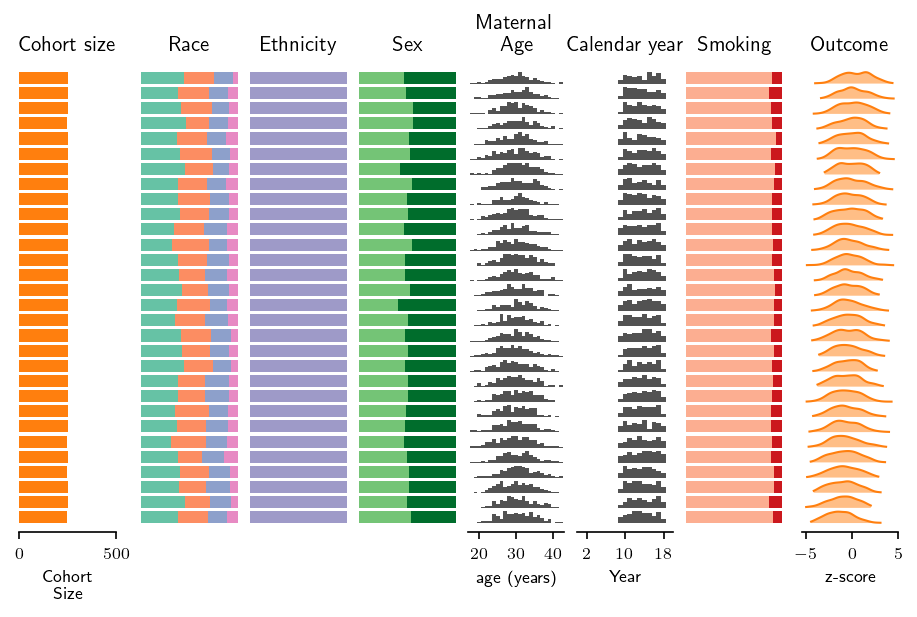

In [29]:
fig00a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig00a, example_data00)
fig00a

It looks like we have uniform sizes, and the data are drawn from similar distributions.

And then we can summarize on a per-cohort basis

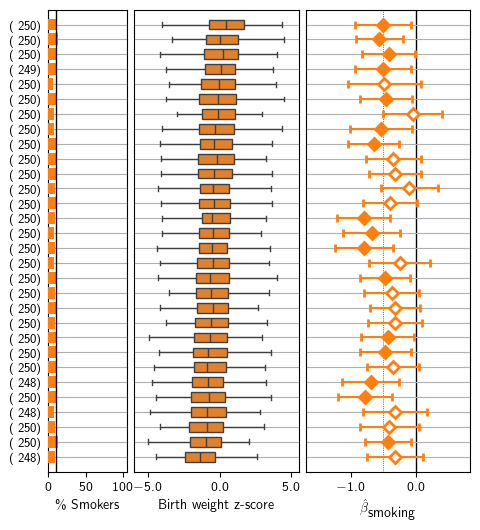

In [30]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params00, lim_scale=0.85)

fig_00b = plt.figure(dpi=100, constrained_layout=0, 
                  figsize=(6, 6), facecolor='w')

gs = fig_00b.add_gridspec(4, 11)
ax01 = fig_00b.add_subplot(gs[:, 3:7])
ax00 = fig_00b.add_subplot(gs[:, 1:3], sharey=ax01)
ax02 = fig_00b.add_subplot(gs[:, 7:], sharey=ax01)


exp_plots.plot_weight_dist(ax1=ax01, 
                           example_data=example_data00, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1.25},
                           box_kws={'linewidth': 1, 'width':0.65})

exp_plots.plot_perc(ax00, example_summary00)

exp_plots.plot_bars(ax2=ax02, 
                    example_summary=example_summary00, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax00.set_yticks(example_summary00['x_pos'])
ax00.set_yticklabels([f'({x:>4.0f})' for x in example_summary00['count']])
ax00.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax01.set_xlim(ax01.get_xlim()[0] - np.diff(ax01.get_xlim()) * 0.05,
              ax01.get_xlim()[1] + np.diff(ax01.get_xlim()) * 0.05)
                                           
# ax00.set_xticks(np.linspace(0, 1, 3))
ax01.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax02.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))

ax01.set_ylabel('Cohort', size=12)
ax01.yaxis.get_label().set_visible(False)
ax00.yaxis.get_label().set_visible(True)
ax00.set_ylim(ax00.get_ylim()[::-1])
_ = ax02.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_00b

And then we can also look at the overall results under different models.

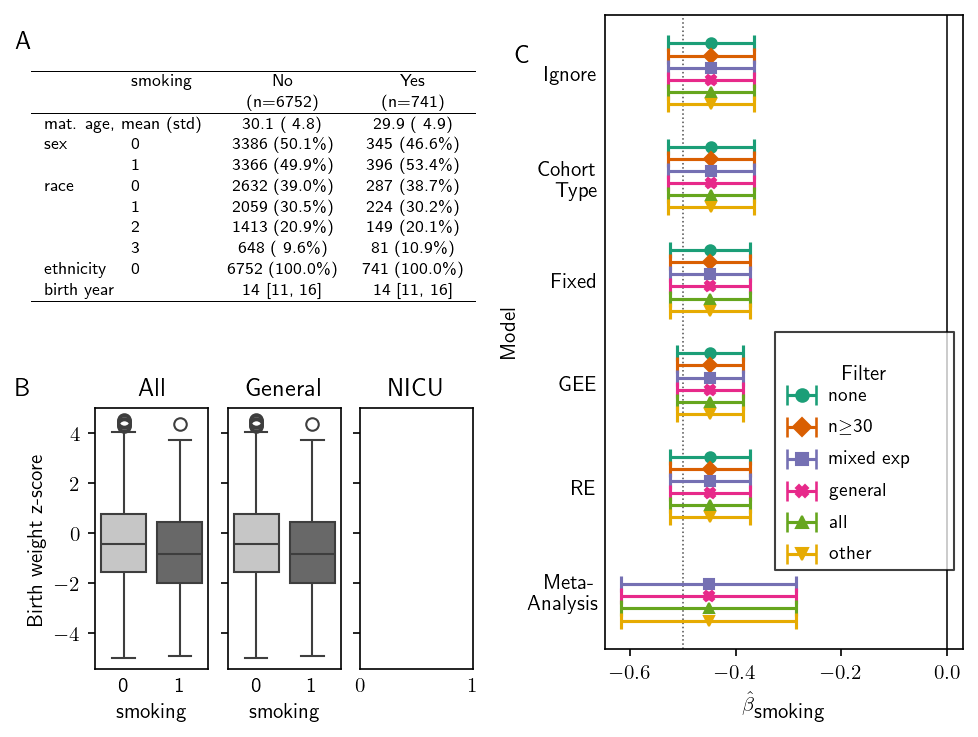

In [31]:
fig00c = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
figr, figl = fig00c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res00, ax, -0.5, tidy_short=tidy_short, 
                             filter_order=filter_order, filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data00), )

gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data00)
    
    
    
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig00c

### Vary Population

Next, I want to look at what happens when we vary the population but keep the cohort sizes, exposure, and outcome characteristics the same.

In [32]:
scenario_bool, seed_kwargs = scenarios_lo_var[1]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data01, sim_values01 = \
    bw_sim.simulate_cohort(**sim_seeds,
                           betas=slopes,
                           icc=seed_var[0.01],
                           smoking_effect=-0.5,
                           exposure_demo_mod=smoking_effect,
                           )
example_summary01 = exp_plots.tabulate_example_data(
    example_data01, levels=['cohort_type', 'mean', 'param'])
example_data01['x'] = \
    example_data01['cohort'].replace(example_summary01['x_pos'].astype(str)).astype(float)
example_params01 = exp_plots.build_per_cohort_fit(example_data01)
fit_res01 = exp_plots.build_filter_fits(example_data01, filters, models, tech_order)
fit_res01 = exp_plots.tabulate_res(fit_res01, filter_order, tech_order, palette='Dark2')

vary
uniform sizes


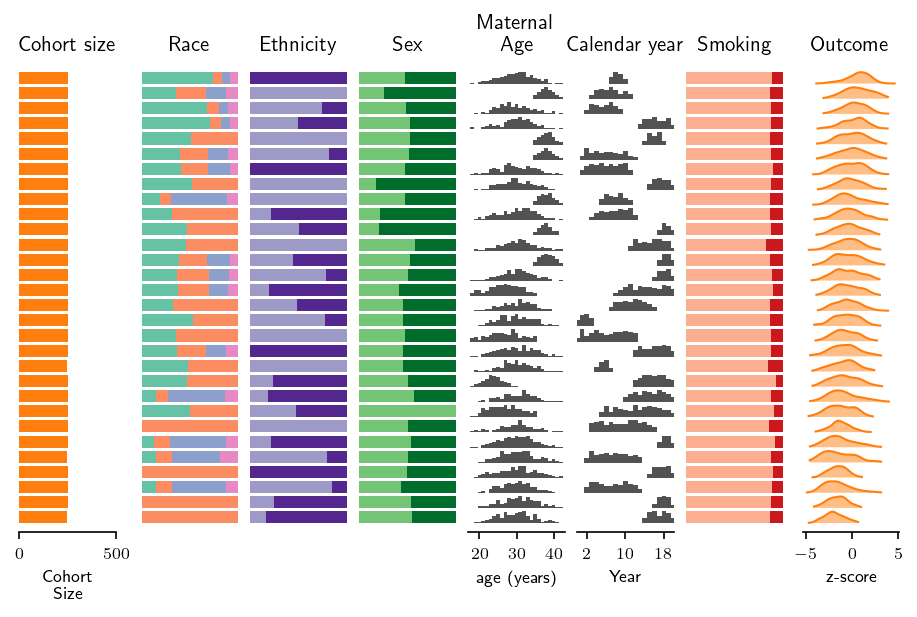

In [33]:
fig01a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig01a, example_data01)
fig01a

So, as exected the cohort composition is varied 

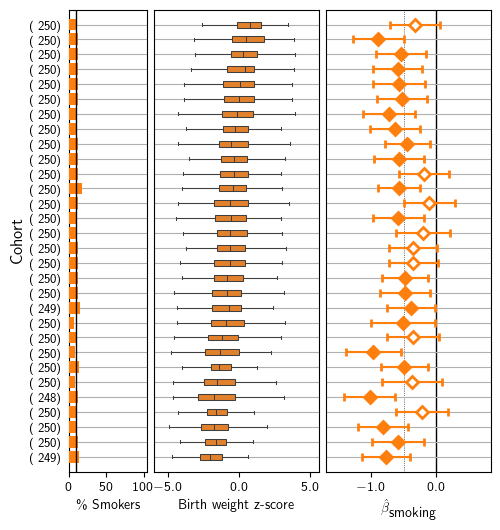

In [34]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params01, lim_scale=0.85)

fig_01b = plt.figure(dpi=100, constrained_layout=0, 
                  figsize=(6, 6), facecolor='None')

gs = fig_01b.add_gridspec(4, 11)
ax11 = fig_01b.add_subplot(gs[:, 3:7])
ax10 = fig_01b.add_subplot(gs[:, 1:3], sharey=ax11)
ax12 = fig_01b.add_subplot(gs[:, 7:], sharey=ax11)

exp_plots.plot_weight_dist(ax1=ax11, 
                           example_data=example_data01, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1})

exp_plots.plot_perc(ax10, example_summary01)

exp_plots.plot_bars(ax2=ax12, 
                    example_summary=example_summary01, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax10.set_yticks(example_summary01['x_pos'])
ax10.set_yticklabels([f'({x:>4.0f})' for x in example_summary01['count']])
ax10.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax10.set_xticks(np.linspace(0, 1, 3))
ax11.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax12.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax11.set_xlim(ax11.get_xlim()[0] - np.diff(ax11.get_xlim()) * 0.05,
              ax11.get_xlim()[1] + np.diff(ax11.get_xlim()) * 0.05)

ax10.set_ylabel('Cohort', size=12)
ax11.yaxis.get_label().set_visible(False)
ax11.set_ylim(ax11.get_ylim()[::-1])
_ = ax12.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_01b

For the example figure, each row is a cohort. The cohorts are labeled by the number of samples in the cohort. The first axis shows the percent of smokers in the cohort; the middle shows the distribution of birth weight z-scores within the cohort. The upper violin shows the overall distribution of data, the box shows the 25-75% interquartile region with median. The final panel shows the estimated effect of smoking by cohort with the 95% CI. The solid line indicates no effect; the thin dashed line is the seed effect. Filled cells indicate a statistically significant effect; non-filled cells indicate the effect estimate was not statistically significant.

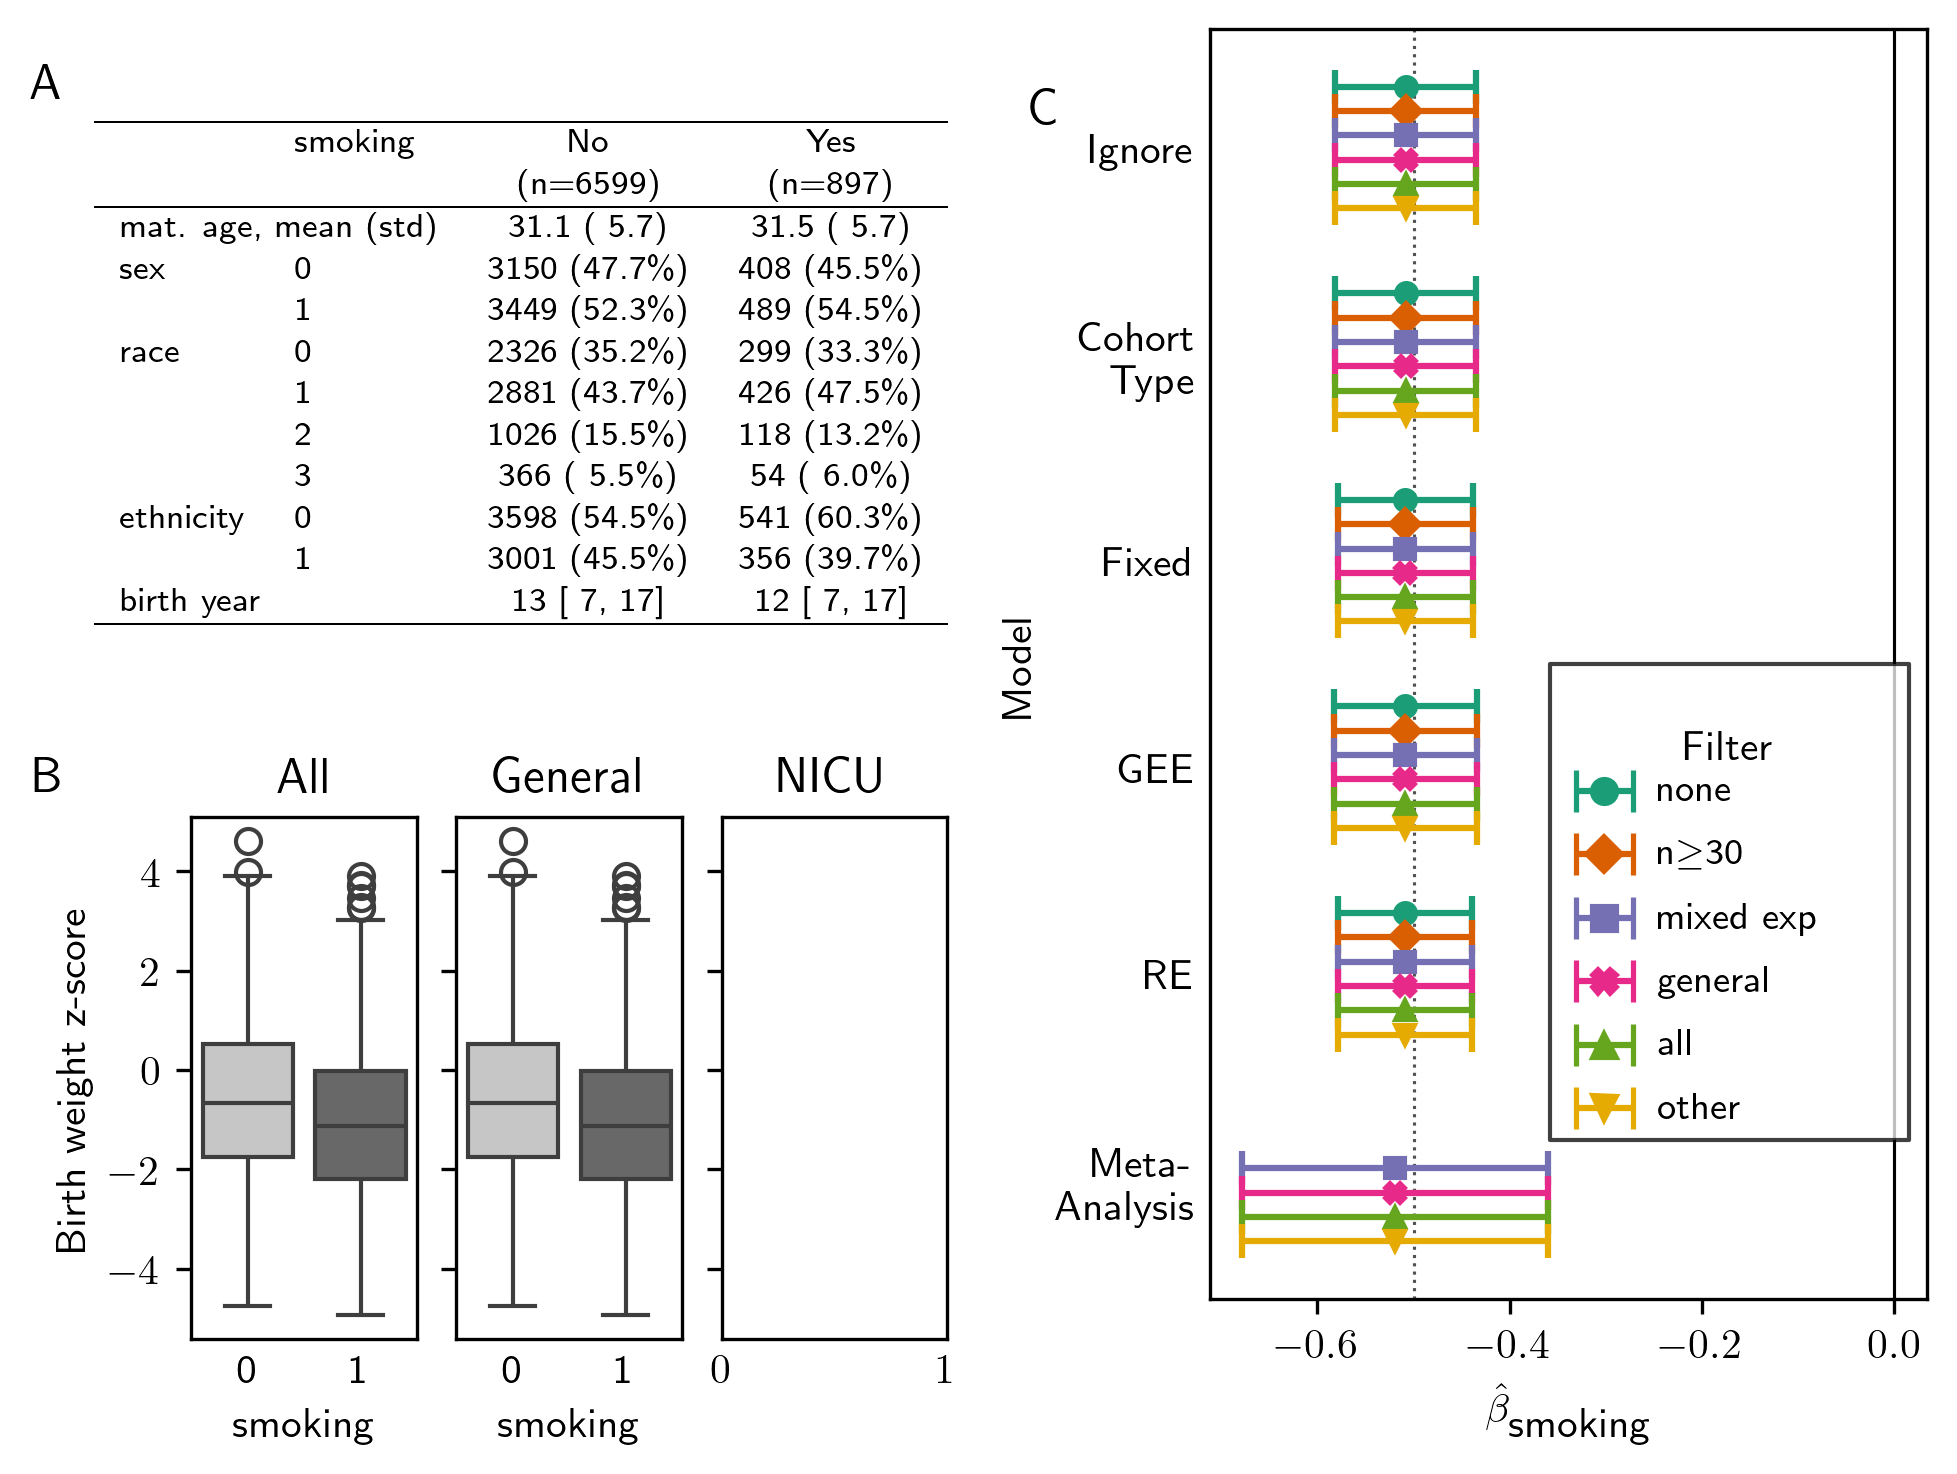

In [35]:
fig01c = plt.figure(dpi=300, constrained_layout=True, facecolor='None')
figr, figl = fig01c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res01, ax, -0.5, 
                             tidy_short=tidy_short, 
                             filter_order=filter_order,
                             filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data01), )
# Disribution plots
gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data01)

# Labels
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig01c

### Vary size

We'll keep the source population, exposure, and outcome the same but vary the population size.

In [36]:
scenario_bool, seed_kwargs = scenarios_lo_var[2]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data02, sim_values02 = \
    bw_sim.simulate_cohort(**sim_seeds,
                           betas=slopes,
                           icc=seed_var[0.01],
                           smoking_effect=-0.5,
                           exposure_demo_mod=smoking_effect,
                           )
example_summary02 = exp_plots.tabulate_example_data(
    example_data02, levels=['cohort_type', 'mean', 'param'])
example_data02['x'] = \
    example_data02['cohort'].replace(example_summary02['x_pos'].astype(str)).astype(float)
example_params02 = exp_plots.build_per_cohort_fit(example_data02)
fit_res02 = exp_plots.build_filter_fits(example_data02, filters, models, tech_order)
fit_res02 = exp_plots.tabulate_res(fit_res02, filter_order, tech_order, palette='Dark2')


uniform
vary sizes


And then we'll look at varying the cohort size but keeping everything else the same.

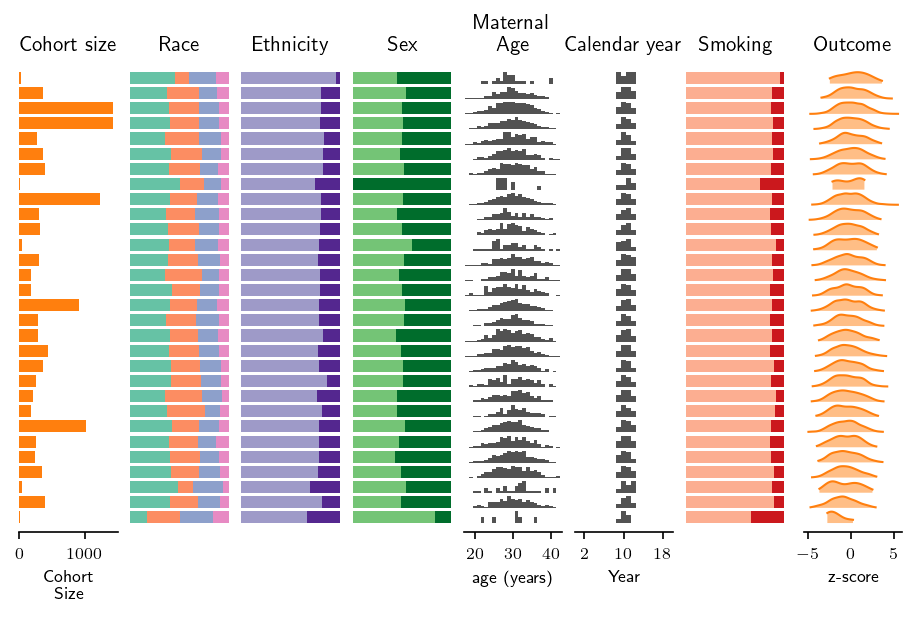

In [37]:
fig02a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig02a, example_data02)
fig02a

And then we'll again look per-cohort

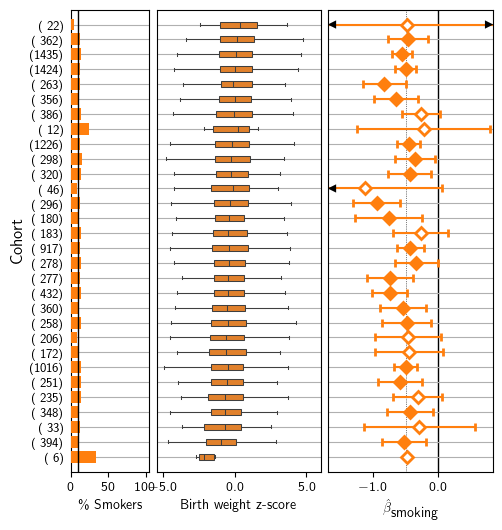

In [38]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params02, lim_scale=0.85)

fig_02b = plt.figure(dpi=100, constrained_layout=0, 
                  figsize=(6, 6), facecolor='None')

gs = fig_02b.add_gridspec(4, 11)
# axn = fig_.add_subplot(gs[:, 0], facecolor='None')
ax21 = fig_02b.add_subplot(gs[:, 3:7])
ax20 = fig_02b.add_subplot(gs[:, 1:3], sharey=ax21)
ax22 = fig_02b.add_subplot(gs[:, 7:], sharey=ax21)

exp_plots.plot_weight_dist(ax1=ax21, 
                           example_data=example_data02, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1})

exp_plots.plot_perc(ax20, example_summary02)

exp_plots.plot_bars(ax2=ax22, 
                    example_summary=example_summary02, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax20.set_yticks(example_summary02['x_pos'])
ax20.set_yticklabels([f'({x:>4.0f})' for x in example_summary02['count']])
ax20.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax20.set_xticks(np.linspace(0, 1, 3))
ax21.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax22.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))

ax20.set_ylabel('Cohort', size=12)
ax21.yaxis.get_label().set_visible(False)
ax21.set_ylim(ax21.get_ylim()[::-1])
_ = ax22.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_02b

And finally, we'll check the overall estimates

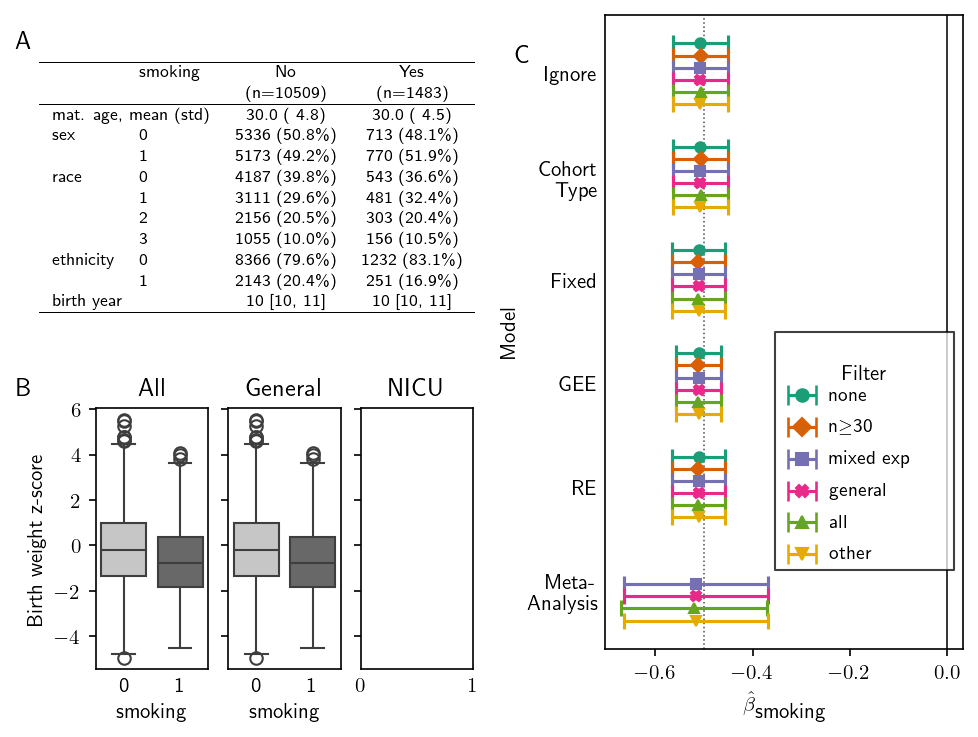

In [39]:
fig02c = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
figr, figl = fig02c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res02, ax, -0.5, 
                             tidy_short=tidy_short, 
                             filter_order=filter_order,
                             filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data02), )
# Disribution plots
gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data02)

# Labels
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig02c

### Vary Exposure

Next, we'll try varying whether the cohort is fully exposed, unexposed, enriched for exposure (e.g. a case-control study) or the population rate of exposure

In [40]:
scenario_bool, seed_kwargs = scenarios_lo_var[3]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data03, sim_values03 = \
    bw_sim.simulate_cohort(**sim_seeds,
                           betas=slopes,
                           icc=seed_var[0.01],
                           smoking_effect=-0.5,
                           exposure_demo_mod=smoking_effect,
                           )
example_summary03 = exp_plots.tabulate_example_data(
    example_data03, levels=['cohort_type', 'mean', 'param'])
example_data03['x'] = \
    example_data03['cohort'].replace(example_summary03['x_pos'].astype(str)).astype(float)
example_params03 = exp_plots.build_per_cohort_fit(example_data03)
fit_res03 = exp_plots.build_filter_fits(example_data03, filters, models, tech_order)
fit_res03 = exp_plots.tabulate_res(fit_res03, filter_order, tech_order, palette='Dark2')

uniform
uniform sizes


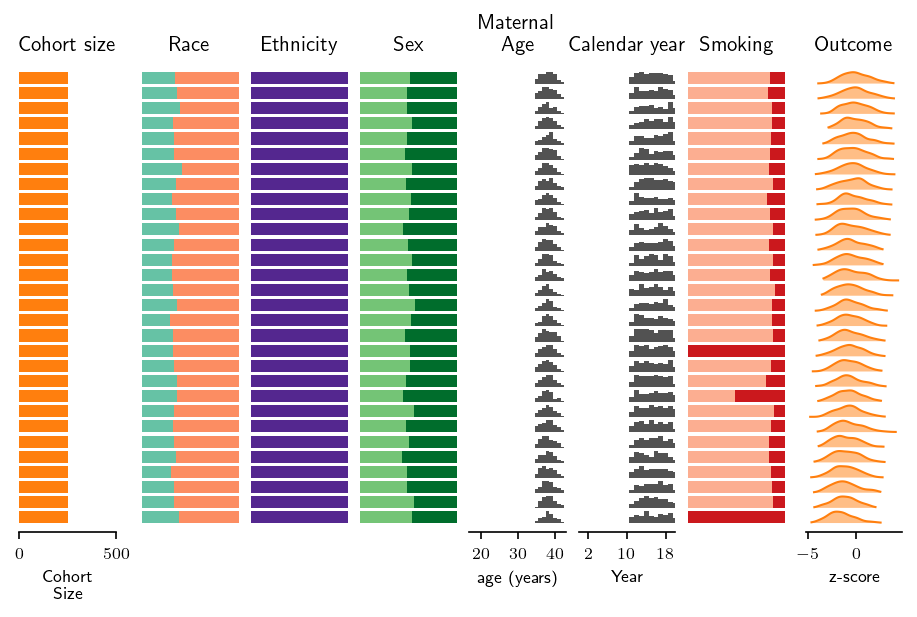

In [41]:
fig03a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig03a, example_data03)
fig03a

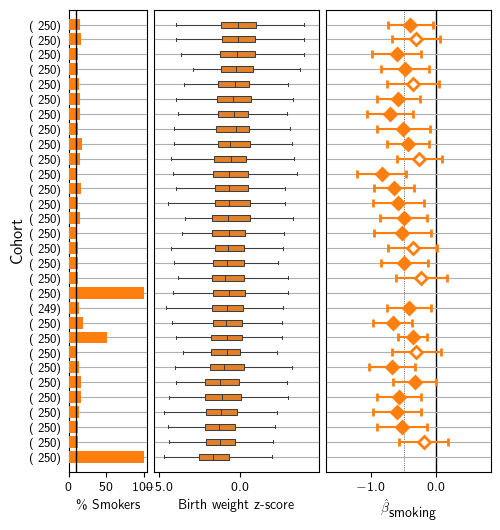

In [42]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params03, lim_scale=0.85)

fig_03b = plt.figure(dpi=100, constrained_layout=0, 
                  figsize=(6, 6), facecolor='None')

gs = fig_03b.add_gridspec(4, 11)
# axn = fig_.add_subplot(gs[:, 0], facecolor='None')
ax31 = fig_03b.add_subplot(gs[:, 3:7])
ax30 = fig_03b.add_subplot(gs[:, 1:3], sharey=ax31)
ax32 = fig_03b.add_subplot(gs[:, 7:], sharey=ax31)

exp_plots.plot_weight_dist(ax1=ax31, 
                           example_data=example_data03, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1})

exp_plots.plot_perc(ax30, example_summary03)

exp_plots.plot_bars(ax2=ax32, 
                    example_summary=example_summary03, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax30.set_yticks(example_summary03['x_pos'])
ax30.set_yticklabels([f'({x:>4.0f})' for x in example_summary03['count']])
ax30.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax30.set_xticks(np.linspace(0, 1, 3))
ax31.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax32.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))

ax30.set_ylabel('Cohort', size=12)
ax31.yaxis.get_label().set_visible(False)
ax31.set_ylim(ax31.get_ylim()[::-1])
_ = ax32.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_03b

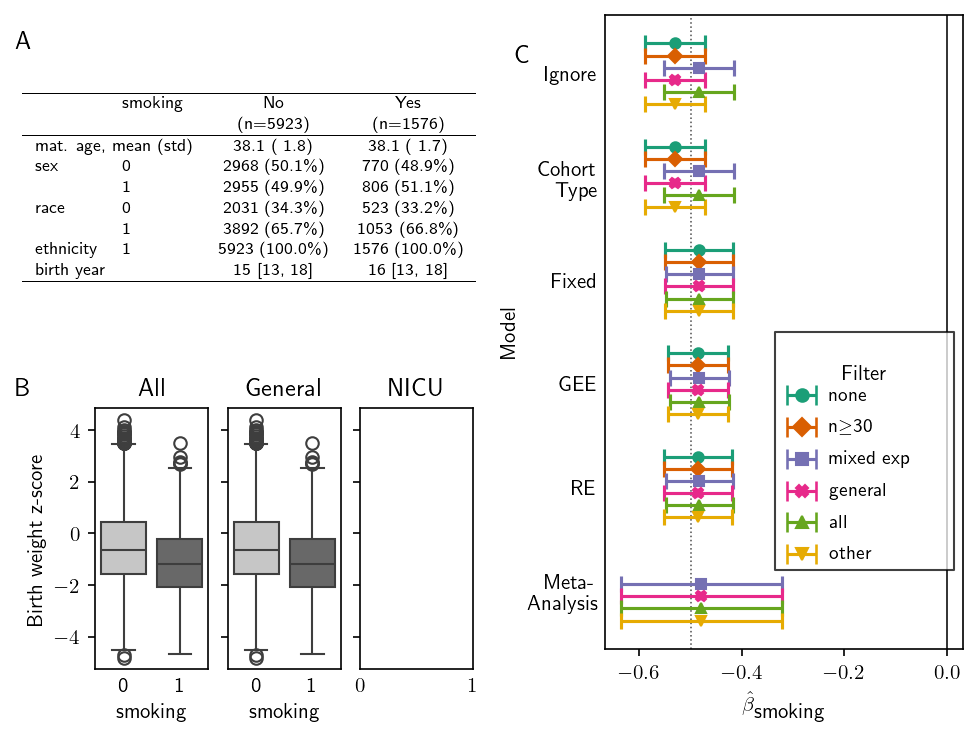

In [43]:
fig03c = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
figr, figl = fig03c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res03, ax, -0.5, 
                             tidy_short=tidy_short, 
                             filter_order=filter_order,
                             filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data03), )
# Disribution plots
gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data03)

# Labels
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig03c

### Vary Outcome

In this simulation, we'll introduce outcome enrichd cohorts (e.g. NICU cohorts)

In [44]:
scenario_bool, seed_kwargs = scenarios_lo_var[4]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data04, sim_values04 = \
    bw_sim.simulate_cohort(**sim_seeds,
                           betas=slopes,
                           icc=seed_var[0.01],
                           smoking_effect=-0.5,
                           exposure_demo_mod=smoking_effect,
                           )
example_summary04 = exp_plots.tabulate_example_data(
    example_data04, levels=['cohort_type', 'mean', 'param'])
example_data04['x'] = \
    example_data04['cohort'].replace(example_summary04['x_pos'].astype(str)).astype(float)
example_params04 = exp_plots.build_per_cohort_fit(example_data04)
fit_res04 = exp_plots.build_filter_fits(example_data04, filters, models, tech_order)
fit_res04 = exp_plots.tabulate_res(fit_res04, filter_order, tech_order, palette='Dark2')

uniform
uniform sizes


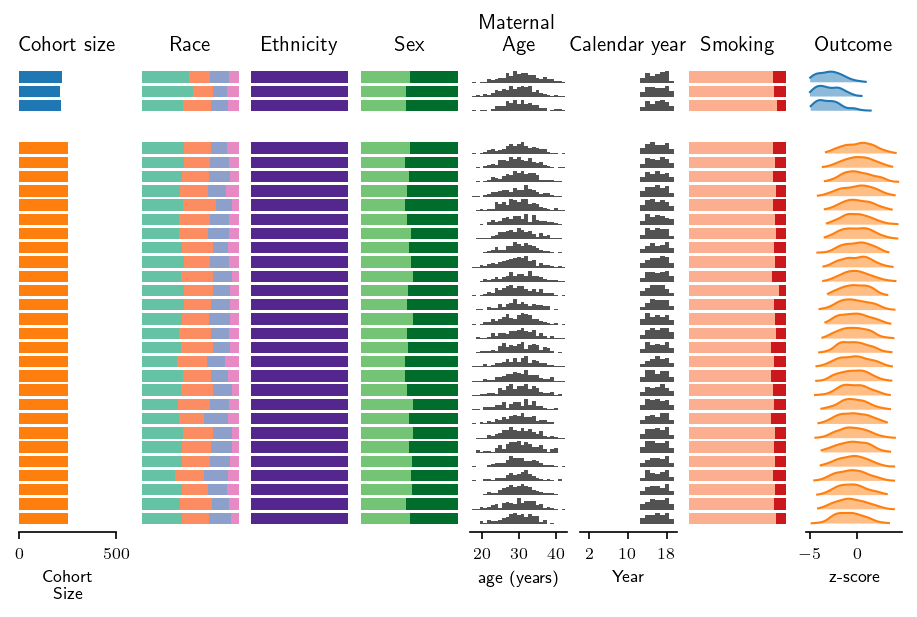

In [45]:
fig04a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig04a, example_data04)
fig04a

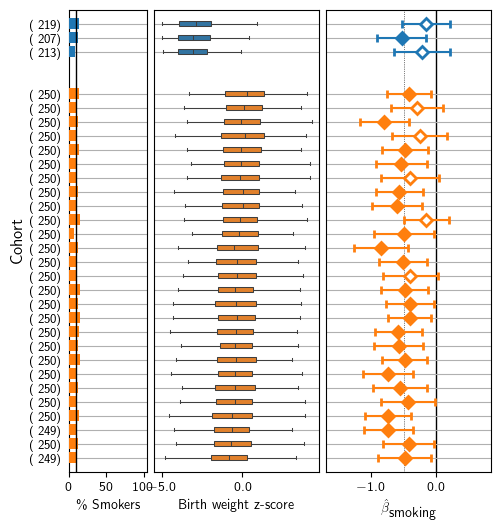

In [46]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params04, lim_scale=0.85)

fig_04b = plt.figure(dpi=100, constrained_layout=0, 
                  figsize=(6, 6), facecolor='None')

gs = fig_04b.add_gridspec(4, 11)
ax41 = fig_04b.add_subplot(gs[:, 3:7])
ax40 = fig_04b.add_subplot(gs[:, 1:3], sharey=ax41)
ax42 = fig_04b.add_subplot(gs[:, 7:], sharey=ax41)

exp_plots.plot_weight_dist(ax1=ax41, 
                           example_data=example_data04, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1.25})

exp_plots.plot_perc(ax40, example_summary04)

exp_plots.plot_bars(ax2=ax42, 
                    example_summary=example_summary04, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax40.set_yticks(example_summary04['x_pos'])
ax40.set_yticklabels([f'({x:>4.0f})' for x in example_summary04['count']])
ax40.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax40.set_xticks(np.linspace(0, 1, 3))
ax41.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax42.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))

ax40.set_ylabel('Cohort', size=12)
ax41.yaxis.get_label().set_visible(False)
ax41.set_ylim(ax41.get_ylim()[::-1])
_ = ax42.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_04b

We'll also summarize the pooled fit

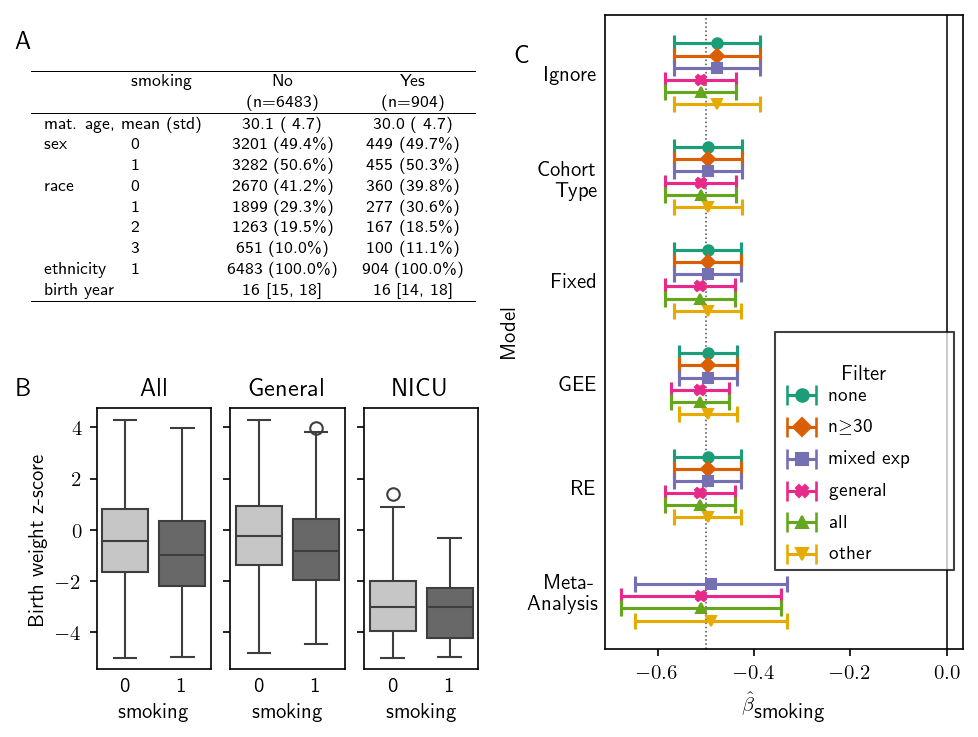

In [47]:
fig04c = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
figr, figl = fig04c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res04, ax, -0.5, 
                             tidy_short=tidy_short, 
                             filter_order=filter_order,
                             filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data04), )
# Disribution plots
gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data04)

# Labels
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig04c

### All Varied

I want to try and build an example scenario so I just check what the data looks like. For this scenario, wer're going to look at varying the source population, varying the cohort size, varying the exposure selection and varying the outcome and we'll look at 30 cohorts.

In [48]:
scenario_bool, seed_kwargs = scenarios_lo_var[-1]
sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=30)

example_data, sim_values = bw_sim.simulate_cohort(**sim_seeds,
                                                  betas=slopes,
                                                  icc=seed_var[0.1],
                                                  smoking_effect=-0.5,
                                                  exposure_demo_mod=smoking_effect,
                                                  # slope_var=0,
                                                  )
example_summary = exp_plots.tabulate_example_data(
    example_data, levels=['cohort_type', 'mean', 'param'])
example_data['x'] = \
    example_data['cohort'].replace(example_summary['x_pos'].astype(str)).astype(float)
example_params = exp_plots.build_per_cohort_fit(example_data)
fit_res = exp_plots.build_filter_fits(example_data, filters, models, tech_order)
fit_res = exp_plots.tabulate_res(fit_res, filter_order, tech_order, palette='Dark2')

vary
vary sizes


Let's look at the simulated data, to see how our varying simulations and population sizes worked out.

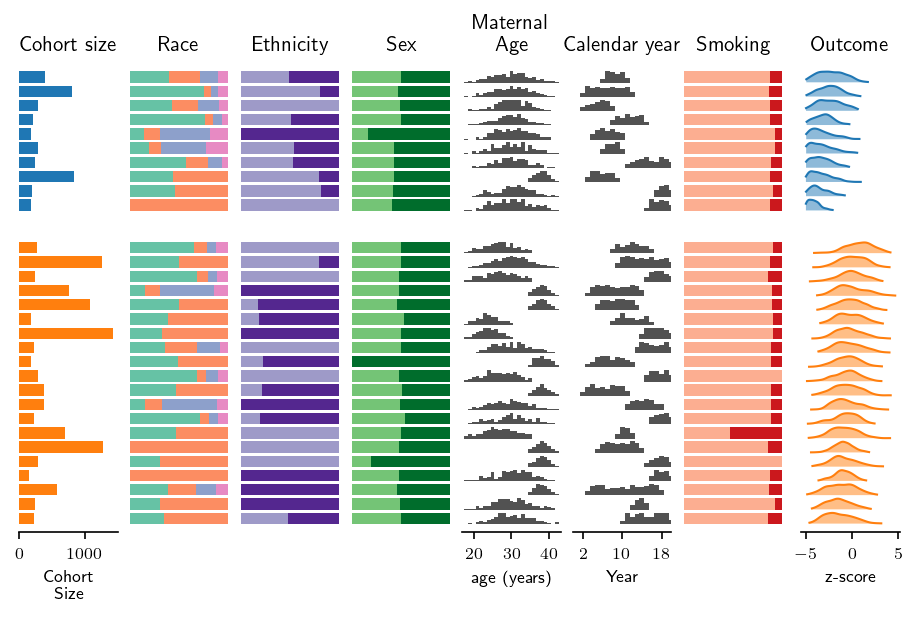

In [49]:
fig06a = plt.figure(dpi=150, constrained_layout=True, figsize=(6, 4))
exp_plots.summarize_simulated_cohorts(fig06a, example_data)
fig06a

And then we can summarize by cohort

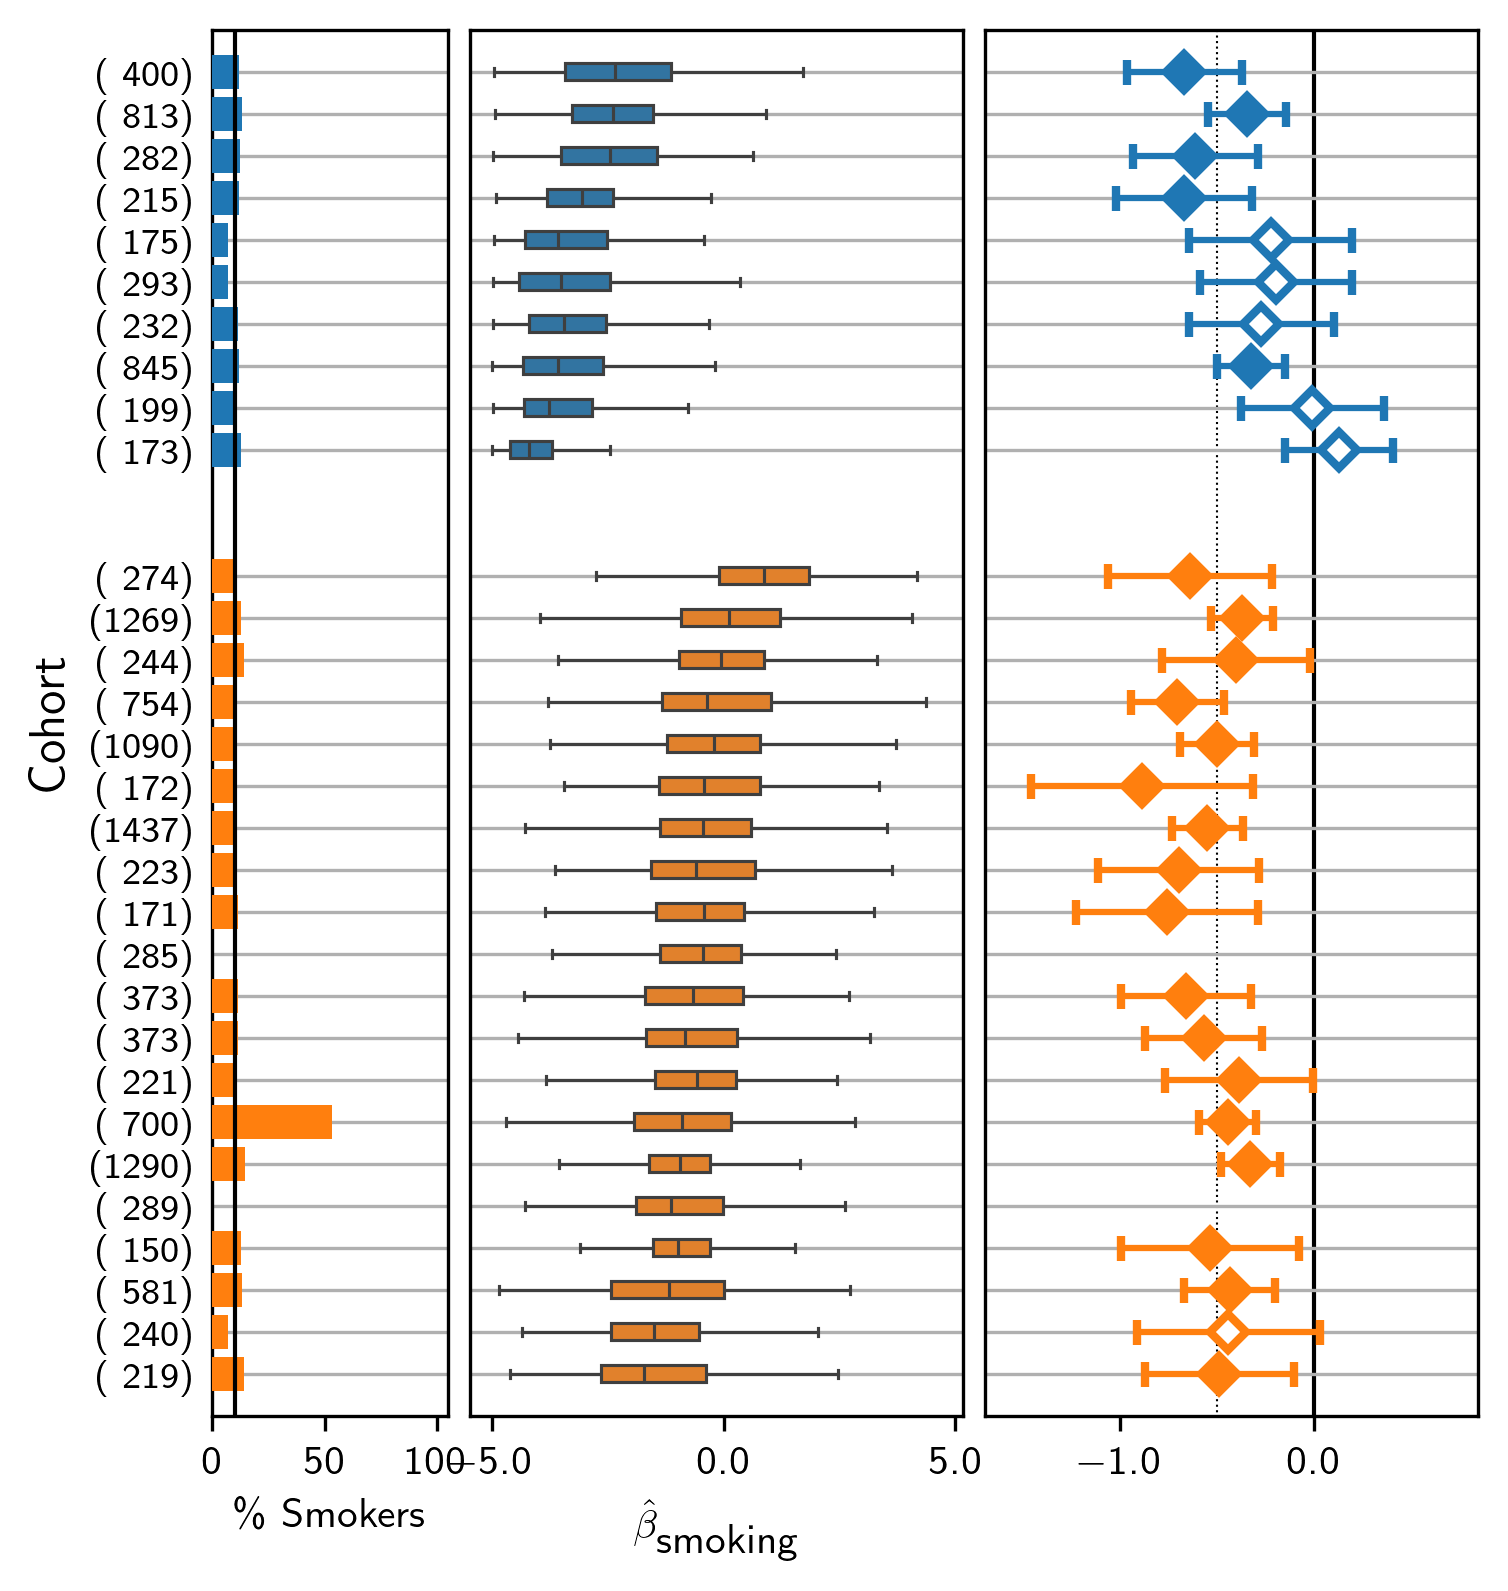

In [50]:
left, right, main_lims, (lo_min, lo_max), (hi_min, hi_max) = \
    exp_plots.calculate_example_scale(example_params, lim_scale=0.85)

fig_06b = plt.figure(dpi=300, constrained_layout=0, 
                  figsize=(6, 6), facecolor='None')

gs = fig_06b.add_gridspec(4, 11)
ax61 = fig_06b.add_subplot(gs[:, 3:7])
ax60 = fig_06b.add_subplot(gs[:, 1:3], sharey=ax61)
ax62 = fig_06b.add_subplot(gs[:, 7:], sharey=ax61)

exp_plots.plot_weight_dist(ax1=ax61, 
                           example_data=example_data, 
                           palette=cohort_type_palette,
                           violin_kws={'width': 1.25})

exp_plots.plot_perc(ax60, example_summary)

exp_plots.plot_bars(ax2=ax62, 
                    example_summary=example_summary, 
                    lim_min=main_lims[0], 
                    lim_max=main_lims[1], 
                    left=left, 
                    right=right, 
                    effect=-0.5,  
                    # markeredgewidth=1,
                    # linewidth=1,
                    # markersize=4,
                    )

_ = ax60.set_yticks(example_summary['x_pos'])
ax60.set_yticklabels([f'({x:>4.0f})' for x in example_summary['count']])
ax60.yaxis.set_tick_params(labelleft=True, labelsize=9)
ax60.set_xticks(np.linspace(0, 1, 3))
ax61.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
ax62.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))

ax60.set_ylabel('Cohort', size=12)
ax61.yaxis.get_label().set_visible(False)
ax61.set_ylim(ax61.get_ylim()[::-1])
_ = ax61.set_xlabel('$\\hat{{\\beta}}_{\\textsf{smoking}}$')
fig_06b

And then we can summarize the data

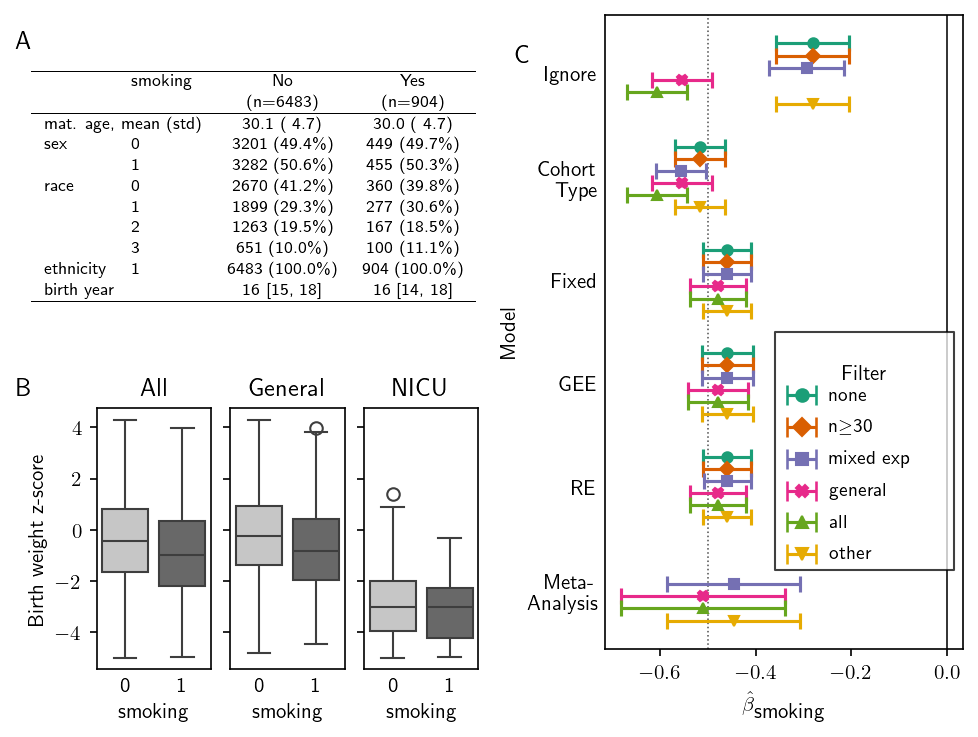

In [51]:
fig06c = plt.figure(dpi=150, constrained_layout=True, facecolor='None')
figr, figl = fig06c.subfigures(1, 2,)
figr0, figr1 = figr.subfigures(2, 1)

# Forest plot
ax = figl.add_subplot(1,1,1)
exp_plots.plot_filtered_fits(fit_res, ax, -0.5, 
                             tidy_short=tidy_short, 
                             filter_order=filter_order,
                             filter_tidy=filter_tidy)


# Table 1
axr0 = figr0.add_subplot(1,1,1, facecolor='None',)
exp_plots.plot_table_1(axr0, exp_plots.build_table1(example_data04), )
# Disribution plots
gsr1 = figr1.add_gridspec(1, 3)
violin_axes = [figr1.add_subplot(gsr1[0])]
violin_axes.append(figr1.add_subplot(gsr1[1], sharey=violin_axes[0]))
violin_axes.append(figr1.add_subplot(gsr1[2], sharey=violin_axes[0]))
exp_plots.plot_pooled_violin(violin_axes, example_data04)

# Labels
axr0.text(axr0.get_xlim()[0] - np.diff(axr0.get_xlim()) * 0.1,
          axr0.get_ylim()[1] - np.diff(axr0.get_ylim()) * 0.1, 
         'A', size=12)
figr1.axes[0].text(figr1.axes[0].get_xlim()[0] - np.diff(figr1.axes[0].get_xlim()) * 0.70,
               figr1.axes[0].get_ylim()[1] + np.diff(figr1.axes[0].get_ylim()) * 0.05,
              'B', size=12
              )
_ = ax.text(ax.get_xlim()[0] - np.diff(ax.get_xlim()) * 0.25,
        ax.get_ylim()[1] - np.diff(ax.get_ylim()) * 0.075, 
        'C', size=12)
fig06c

#### Simulation Schematic

I also want to use this data to highlight how we do a simulation. We'll use cohort 11 as an example cohort for this.

In [52]:
sub_data = sim_values.loc[example_data['cohort'] == 'cohort_02'].copy()
sub_data.drop(columns=['cohort_slope'], inplace=True)
cohort_data = example_data.loc[example_data['cohort'] == 'cohort_02']

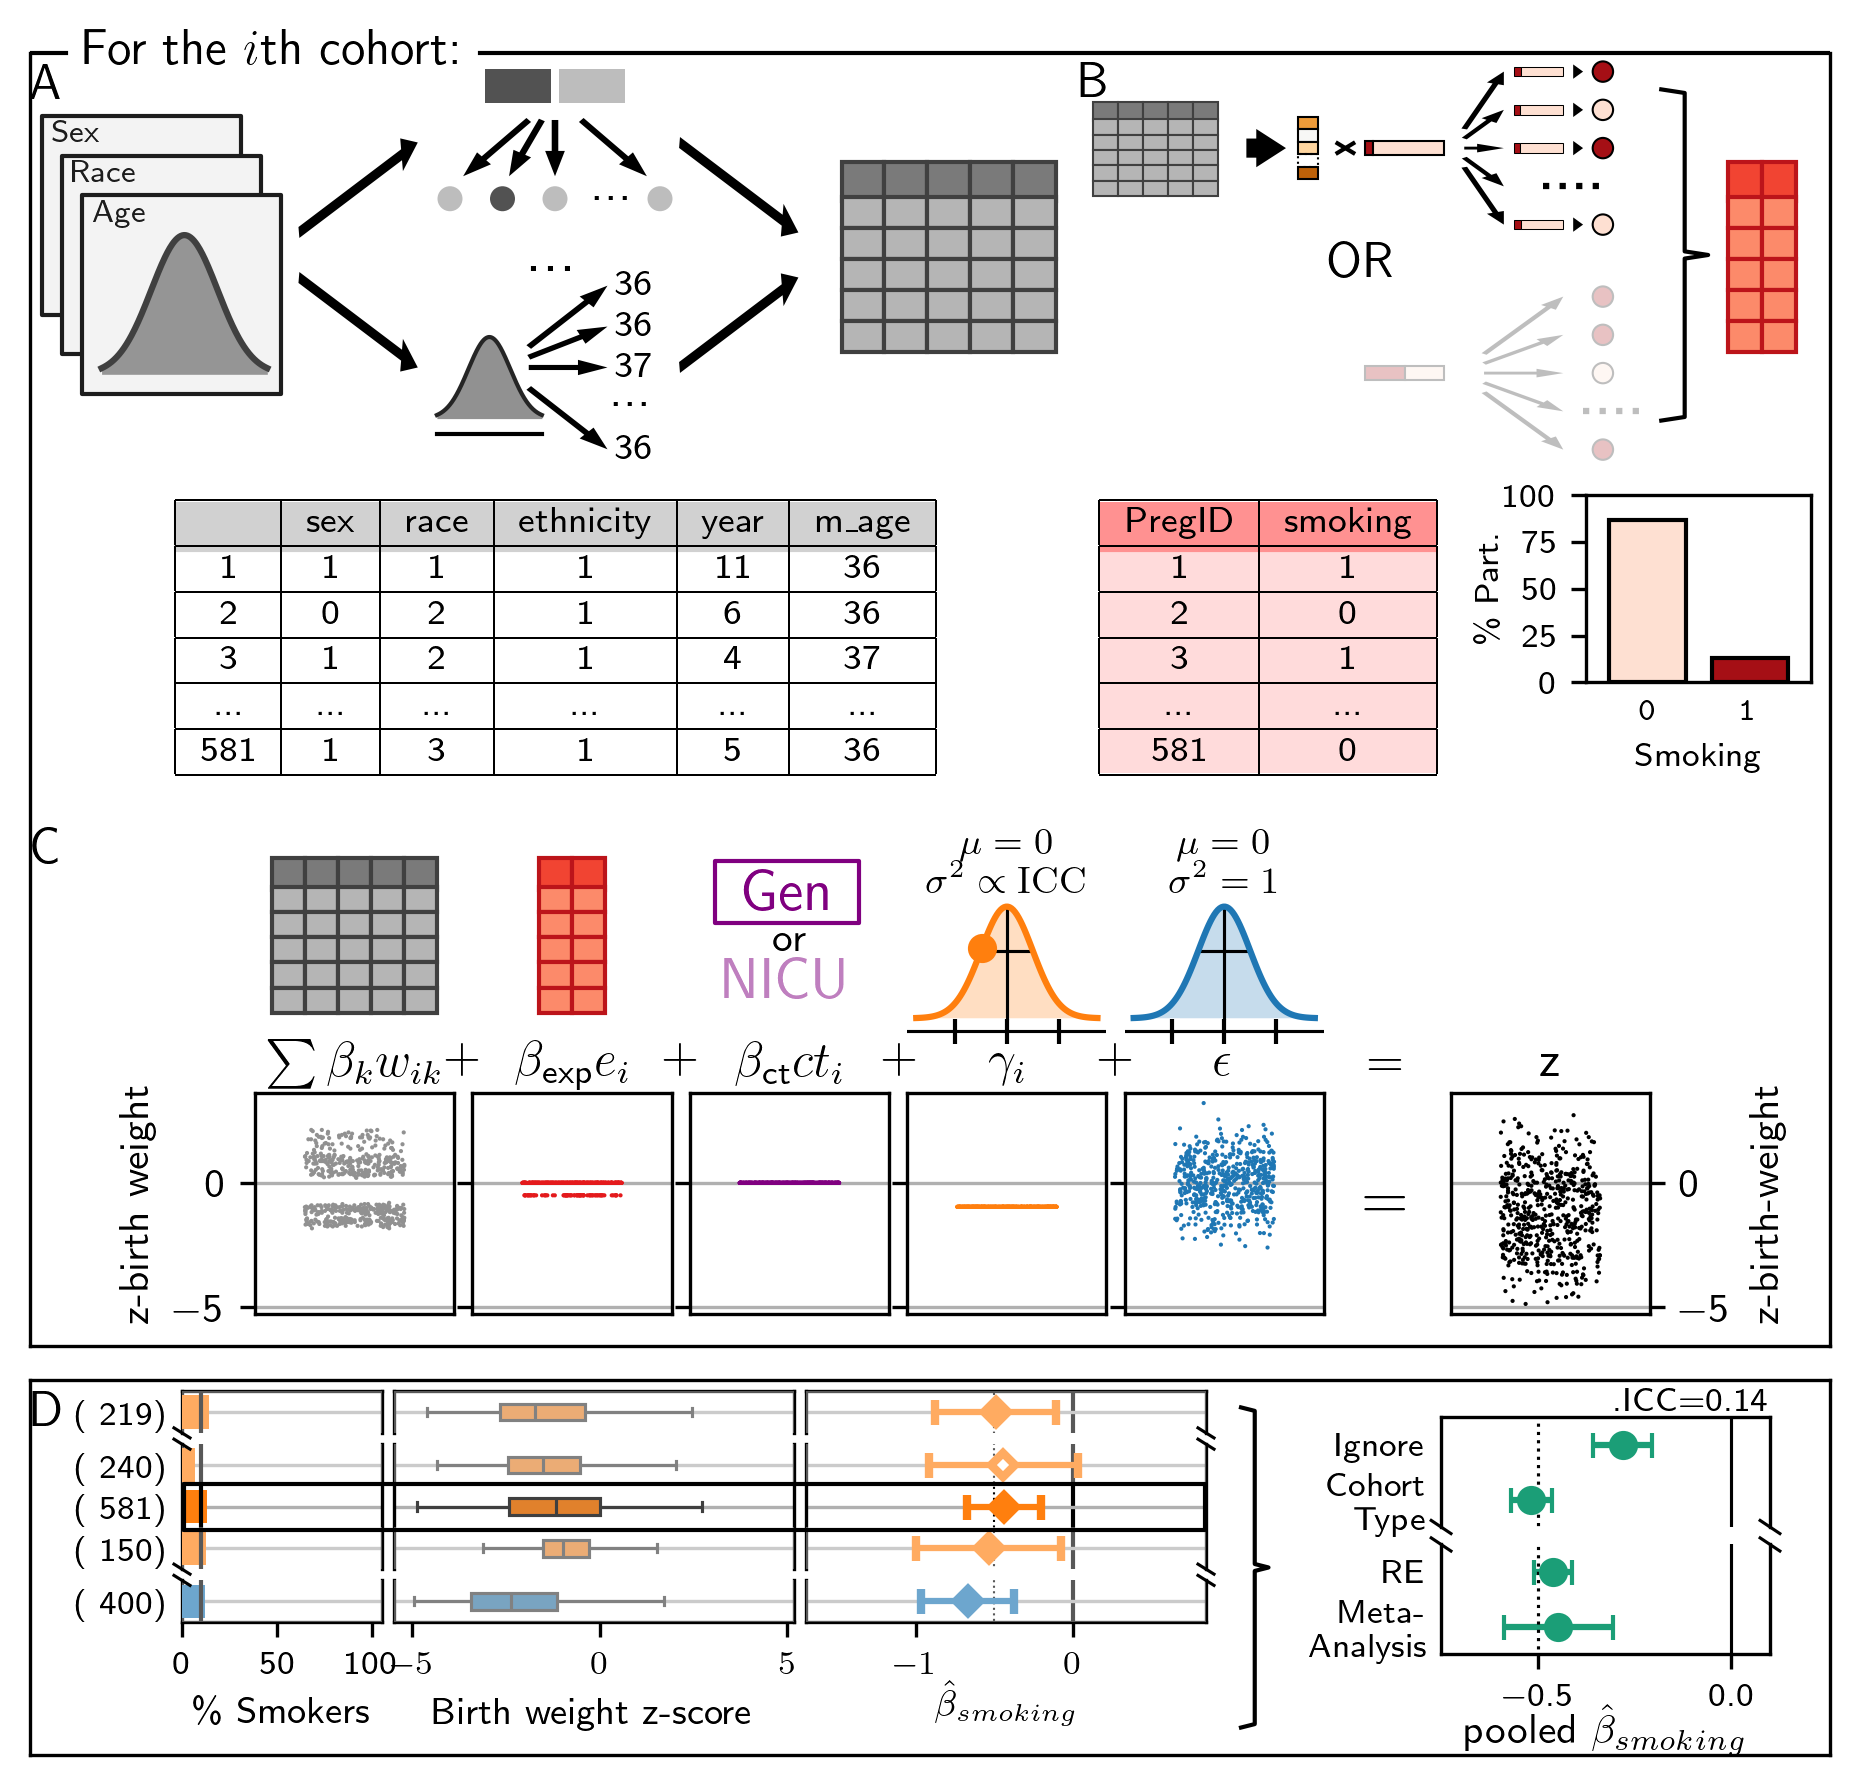

In [53]:
figa = plt.figure(dpi=300, constrained_layout=0, figsize=(6, 5.75), facecolor='w')
fig_ind, fig_dep, fig_c = figa.subfigures(3, 1, height_ratios=[2.5, 2, 1.25])
fig_dem, fig_exp1 = fig_ind.subfigures(1, 2, width_ratios=[3.5, 2.5])
figdl, fig_dm = fig_dem.subfigures(2, 1, height_ratios=[1.5, 1])
fig_exp, fig_rand = fig_exp1.subfigures(2, 1, height_ratios=[1.5, 1])
# fig_exp, fig_ext = fig_exp1.subfigures(1, 2, width_ratios=[2, 0.5])
fig_cl, fig_cr = fig_c.subfigures(1, 2, width_ratios=[4, 2])

figw, figi = figa.subfigures(2, 1, height_ratios=[4.5, 1.25])

exp_plots.build_sim_process_ref(figdl, cohort_data)
ax_l = figdl.axes[0]
figdl.axes[0].text(ax_l.get_xlim()[0],
                   ax_l.get_ylim()[1] + np.diff(ax_l.get_ylim()) * 0.01,
                   'A', 
                   size=12
                  )
exp_plots._build_table_plot(fig_dm, cohort_data, n_head=3)

exp_plots._select_exposure(fig_exp, cohort_data, smoking_effect)
ax_l = fig_exp.axes[2]
ax_l.text(ax_l.get_xlim()[0], 
          ax_l.get_ylim()[1] - np.diff(ax_l.get_ylim()) * 0.05, 
          'B', size=12, va='top')
exp_plots.illustrate_exposure_res(fig_rand, cohort_data)

exp_plots.build_sim_sum_icons(fig_dep, sub_data)
ax_l = fig_dep.axes[0]
ax_l.text(ax_l.get_xlim()[0] - 0.16 * np.diff(ax_l.get_xlim()),
          ax_l.get_ylim()[1],
          'C', 
          size=12,
          ha='left',
          va='center'
          )
fig_cl.set_facecolor('None')
exp_plots.build_split_figure(fig_cl, example_summary, example_data, example_params, 
                             clutch=cohort_data['x'].mean())
ax_l = fig_cl.axes[1]
ax_l.text(ax_l.get_xlim()[0] - np.diff(ax_l.get_xlim()) * 0.75, 
          ax_l.get_ylim()[1],
          'D', size=12, ha='left', va='top')

fig_cr.set_facecolor('None')
exp_plots.pooled_res_plot(fig_cr, fit_res=fit_res, example_data=example_data)# )

axw = figw.add_subplot(1,1,1, facecolor='None')
axw.xaxis.set_tick_params(left=False, labelleft=False, 
                          right=False, labelright=False,
                          length=0, labelsize=0)
axw.yaxis.set_tick_params(left=False, labelleft=False, 
                          right=False, labelright=False,
                          length=0, labelsize=0)
axw.set_position((0, 0.025, 1, 0.975))
axw.set_xlim(0, 1)
axw.set_ylim(0, 1)
axw.set_yticks([0, 0.9825])
axw.set_xticks([0, 1])
axw.text(0.03, 1, 'For the $i$th cohort:', size=12, va='top', ha='left')
axw.plot([0, 0.02], [0.9825, 0.9825], 'k-', linewidth=1)
axw.plot([1, 0.25], [0.9825, 0.9825], 'k-', linewidth=1)
sn.despine(ax=axw, left=False, right=False, bottom=False, top=True, trim=True)

axi = figi.add_subplot(1,1,1, facecolor='None')
axi.set_position((0, 0, 1, 1))
axi.set_xlim(0, 1)
axi.set_ylim(0, 1)
axi.xaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)
axi.yaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)

figa

So, now that we've demonstrated the ability to simulate data, let's try applying the imulation trial, varying the different strata.

# Simulation Trials: Single Variations

Then, we can undertake a series of simulation trials, varying  a single parameter. We'll start by selecting a number of simulation trails to run for each ICC, effect size, and scenario.

In [54]:
num_sim = 25
print(f'We will perform {num_sim} trials per scenario, ICC, and effect size strata')

We will perform 25 trials per scenario, ICC, and effect size strata


In [55]:
%%capture
# We use capture to hide the output text and the warnings... becuse I can't deal.
uniform_data = dict()

for a, (scenario_bool, seed_kwargs) in enumerate(scenarios_lo_var):
    print(f'Start {a}')
    fit_iccs = dict()
    for effect, (icc, var) in it.product(effects, seed_var.items()):
        fit_iccs[(effect, icc)] = []
        for i in range(num_sim):
            # Simulates the data 
            sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=20)
            # try:
            data, _ = bw_sim.simulate_cohort(**sim_seeds,
                                              betas=slopes,
                                              icc=var,
                                              smoking_effect=effect,
                                              exposure_demo_mod=smoking_effect,
                                              )
            # except:
                # continue

            # Caclulates the ICC and the general cohort ICC
            fit = smf.mixedlm('y ~ 1', data=data, groups=data['cohort']).fit()
            fit_icc = bw_ana.icc_from_lme(fit)
            if (icc >= 1) | (icc < 0) | np.any(np.trace(fit.cov_params()) < 0):
                fit_icc = 0
            if len(data['cohort_type'].unique()) > 1:
                data2 = data.loc[data['cohort_type'].isin(['0', 0])].copy()
                fit2 = smf.mixedlm('y ~ 1', 
                                   data=data2, 
                                   groups=data2['cohort']).fit()
                fit_icc2 = bw_ana.icc_from_lme(fit2)
                if (fit_icc2 >= 1) | (fit_icc2 < 0) | np.any(np.trace(fit2.cov_params()) < 0):
                    fit_icc2 = 0
            else:
                fit_icc2 = fit_icc
                
            # Filts the data and model
            try:
                model_adj = {
                    (name, fname): model(fit_icc2, f_(data), 'm_age + year + C(race) + C(sex) + C(ethnicity)') 
                    for (name, model) in zip(*(tech_order, models))
                    for (fname, f_) in filters.items()
                    if fname in {'none'}
                    }
                summary = {'data': data, 
                           'fit_icc': fit_icc2,
                           'adj': model_adj,
                           }
                if fit.converged:
                    fit_iccs[(effect, icc)].append(summary)
            except(LinAlgError):
                continue
    code = np.power(2, scenario_bool * np.arange(len(scenario_bool))) * \
        scenario_bool
    code = int(code.sum())
    uniform_data[code] = fit_iccs
    print(f'Finish {a}')

In [56]:
1 + 2

3

In [57]:
# And then once the data gets simulated, we compile the models intoa  longform 
# simulated result
extracted_params = pd.DataFrame.from_dict(
    data={(scenario, eff, seed_icc, i, name, filt_, adj, icc, conv * 1): params
          for scenario, scenario_res in uniform_data.items()
          for (seed_icc, eff), eff_combo in scenario_res.items()
          for i, ds in enumerate(eff_combo)
          for adj in ['adj']
          for (model, filt_), (icc, fit_, params, conv, name) in ds[adj].items()
          },
    orient='index',
)
extracted_params.index.set_names(['scenario', 'seed_icc', 'seed_effect', 'iter', 
                                  'model', 'filter', 'adjustment', 'icc', 
                                  'converged'],
                                 inplace=True)
extracted_params.reset_index(level=['icc', 'converged'], inplace=True)

# We work with the threshholded values for ICC value strata and then we add it
# to the index
thresh = pd.concat(
    axis=0, 
    objs=[extracted_params['icc'] > thresh 
          for thresh in [0.01, 0.05, 0.1, 0.4, 0.7]]
) * 1
extracted_params['icc_group'] = thresh.groupby(list(thresh.index.names)).sum()
extracted_params.set_index('icc_group', append=True, inplace=True)

# And then we'll drop the filter and adjustment index levels since they're 
# consistent for this fit. 
extracted_params.reset_index(level=['filter', 'adjustment'], 
                             inplace=True, 
                             drop=True)

Having run several models, I want to check the converged data, with the caveat that in "meta" analysis, the converged argument is calculated as whether all the cohorts are included.

In [58]:
extracted_params.groupby(['scenario', 'model'])['converged'].mean().unstack()

model,fixed,gee,ignore,lme,meta,risk
scenario,,,,,,
0,1.0,1.000000,1.0,0.961446,1.000000,1.0
1,1.0,1.000000,1.0,0.950113,1.000000,1.0
2,1.0,0.995261,1.0,0.981043,0.841232,1.0
4,1.0,1.000000,1.0,0.969907,0.129630,1.0
8,1.0,1.000000,1.0,0.997778,1.000000,1.0
15,1.0,1.000000,1.0,1.000000,0.151111,1.0


Finally, we'll pull out only the converged data to work with.

In [59]:
uniform_keep = (extracted_params['converged'] | \
    extracted_params.index.to_frame()['model'].isin(['meta'])) & \
    (extracted_params['icc'] >= 0) & (extracted_params['icc'] <= 1)
uniform_params = extracted_params.loc[uniform_keep].copy()
uniform_params.reset_index(level='seed_effect', inplace=True)
uniform_params['from_ref'] = uniform_params['param'] - uniform_params['seed_effect']
uniform_params['abs_diff'] = np.absolute(uniform_params['from_ref'])
uniform_params['sign_diff'] = np.sign(uniform_params['from_ref'])
uniform_params['icc2'] = uniform_params['icc'] / 0.05

In [60]:
trial_count = uniform_params.set_index('seed_effect', append=True).index.to_frame().copy()
trial_count = trial_count.duplicated(['scenario', 'seed_icc', 'seed_effect', 'iter'], keep='first')
trial_count = trial_count == False
trial_count = trial_count.cumsum()
trial_count.reset_index('seed_effect', inplace=True,  drop=True)
uniform_params['unique_trial'] = trial_count

In [61]:
uniform_params.index.to_frame()['scenario'].unique()

array([ 0,  1,  2,  4,  8, 15])

In [62]:
uniform_params.shape

(15581, 13)

In [63]:
scenario_codes = [0, 1, 2, 4, 8, 15]

# Heuristics

## Evil Trees

In an earlier iteration, I also had a figure I described as the "evil tree" figure, which was the 95% confidence interval for different estimates and whether they were significant vs the ICC

In [64]:
uniform_params['include'] = \
    ((uniform_params['ci_lo'] <= uniform_params['seed_effect']) & \
     (uniform_params['ci_hi'] >= uniform_params['seed_effect'])) * 1

uniform_params['sig'] = \
    ((uniform_params['p-value'] < 0.05) |  
    (np.sign(uniform_params['ci_lo']) == np.sign(uniform_params['ci_hi']))) * 1

In [65]:
uniform_params.groupby(['scenario', 'model'])['include'].mean().unstack(
    )[['ignore', 'risk', 'fixed', 'gee', 'lme', 'meta']].round(3)

model,ignore,risk,fixed,gee,lme,meta
scenario,,,,,,
0,0.930,0.930,0.954,0.932,0.952,1.0
1,0.939,0.939,0.941,0.923,0.943,1.0
2,0.945,0.945,0.933,0.904,0.932,1.0
4,0.516,0.516,0.935,0.900,0.933,1.0
8,0.887,0.936,0.942,0.929,0.942,1.0
15,0.362,0.524,0.907,0.862,0.902,1.0


In [66]:
uniform_params.groupby(['seed_effect', 'scenario', 'model'])['sig'].mean().unstack()

model                    fixed       gee    ignore       lme      meta  \
seed_effect scenario                                                     
-0.5        0         1.000000  1.000000  1.000000  1.000000  1.000000   
            1         1.000000  1.000000  1.000000  1.000000  1.000000   
            2         1.000000  1.000000  1.000000  1.000000  1.000000   
            4         1.000000  1.000000  0.972350  1.000000  1.000000   
            8         1.000000  1.000000  1.000000  1.000000  1.000000   
            15        1.000000  1.000000  0.897778  1.000000  1.000000   
-0.1        0         0.599034  0.666667  0.439614  0.600000  0.019324   
            1         0.563636  0.581818  0.440909  0.552885  0.031818   
            2         0.845411  0.854369  0.642512  0.847291  0.019324   
            4         0.646512  0.683721  0.693023  0.650718  0.013953   
            8         0.564444  0.586667  0.226667  0.560000  0.000000   
            15        0.760000  0.795556  0.622222  0.751111  0.004444   

model                     risk  
seed_effect scenario            
-0.5        0         1.000000  
            1         1.000000  
            2         1.000000  
            4         0.972350  
            8         1.000000  
            15        0.982222  
-0.1        0         0.439614  
            1         0.440909  
            2         0.642512  
            4         0.693023  
            8         0.462222  
            15        0.715556

In [67]:
def _scary_tree(fig, gs, ax_ref, i, j, scenario, model, x='icc', 
                uniform_params=uniform_params, **error_kwargs):
    """
    Makes an evil forest plot, highlighting values that don't contain the 
    seed value
    """
    # Pulls out the necessary data
    df_ = uniform_params.xs(scenario, level='scenario')
    df_ = df_.xs(model, level='model').copy()
    # Calculates the width and determines if they include the seed vlaue
    df_['width'] = df_['ci_hi'] - df_['param']
    df_['include'] = \
        (df_['ci_lo'] < df_['seed_effect']) & (df_['ci_hi'] > df_['seed_effect'])
    df_['param2'] = df_['seed_effect'] - df_['param']
    
    # Sets up the axis
    if ax_ref is None:
        ax_ = fig.add_subplot(gs[i, j + 1])
    else:
        ax_ = fig.add_subplot(gs[i, j + 1], sharex=ax_ref, sharey=ax_ref)
    
    # Plots the results
    ax_.errorbar(x=x, y='param2',  yerr='width', 
                data=df_.loc[df_['include']],
                color='#919191',
                **error_kwargs)
    ax_.errorbar(x=x, y='param2',  yerr='width', 
                data=df_.loc[~df_['include']],
                color='red',
                **error_kwargs)

    ax_.xaxis.set_tick_params(bottom=True, labeltop=False, 
                              top=True, labelbottom=False, 
                              tickdir='in', 
                              labelsize=8)
    ax_.yaxis.set_tick_params(left=True, labelleft=False, 
                              right=True, labelright=(j == 5), 
                              tickdir='in', 
                              labelsize=8)
    ax_.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:>5.1f}'))
    ax_.xaxis.get_label().set_visible(False)
    ax_.yaxis.get_label().set_visible(False)
    
    if i == 0:
        ax_.set_title(tidy_short.get(model, model.title()), size=10)
    
    return ax_



In [68]:
def plot_ref_scatter(fig, gs, scenarios, check_mark='x', box_size=None, 
                     boxlinewidth=1,  ax_labels=None, check_color='k'):
    """
    
    """
    for i, (bool_, _) in enumerate(scenarios):
        # Axis
        ax = fig.add_subplot(gs[i, 0], facecolor='None',)
    
        num_factors = len(bool_)
        x_ref = np.linspace(0, 1, num_factors)
        # Generates empty check boxes in each position
        ax.scatter(x=x_ref,
                   y=x_ref * 0,
                   marker='s', 
                   s=box_size, 
                   facecolor='None', 
                   linewidth=boxlinewidth, 
                   edgecolor='k')

        # Figures out the boxes to check and checks them
        x = np.array(bool_) * (x_ref + 1)
        x = x[x > 0] - 1
        ax.scatter(x=x,
                   y=x * 0,
                   s=box_size,
                   marker=check_mark, 
                   color=check_color,
                   )
    
        # Tidies the axis
        ax.set_xlim(-0.15, 1.15)
        ax.set_xticks(np.linspace(0, 1, num_factors))
        ax.set_xticklabels(['Vary population', 'Varying size', 
                            'Exposure selection', 'Outcome selection'], 
                           rotation=90, size=9)
        ax.xaxis.set_tick_params(bottom=False, labeltop=(i == 0), labelbottom=False)
        ax.yaxis.set_tick_params(left=False, labelleft=False)
        sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)

In [69]:
uniform_params.index.to_frame()['scenario'].unique()

array([ 0,  1,  2,  4,  8, 15])

0
1
2
4
8
15


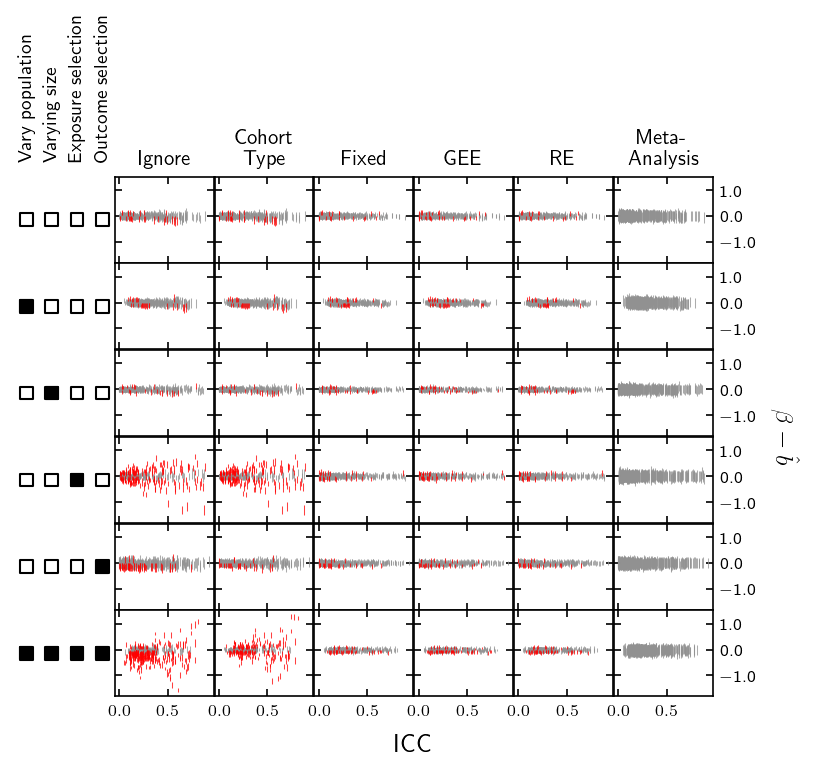

In [70]:
fig = plt.figure(dpi=150, constrained_layout=0, figsize=(6, 4.5))
gs = fig.add_gridspec(6, 7, wspace=0.01, hspace=0.01)

ax_ = None
for i, scenario in enumerate(scenario_codes):
    print(scenario)
    ax_r = []
    for j, model in enumerate(tech_order):
        ax_ = _scary_tree(fig, gs, ax_, i, j, scenario, model, 
                          linestyle='', alpha=0.75, linewidth=0.5)
        ax_.xaxis.set_tick_params(labelbottom=(scenario==15))
plot_ref_scatter(fig=fig, gs=gs, scenarios=scenarios_lo_var, check_mark='s')
        
ax_l = fig.add_subplot(gs[:, 1:], facecolor='None')
ax_l.set_ylabel('$\\beta - \\hat{b}$', size=12, rotation=-90, va='bottom', labelpad=42)
ax_l.yaxis.set_label_position('right')
ax_l.set_xlabel('ICC', size=12, labelpad=18)
ax_l.xaxis.set_tick_params(bottom=False, labelbottom=False, top=False, 
                           labeltop=False, length=0, labelsize=0)
ax_l.yaxis.set_tick_params(bottom=False, labelbottom=False, top=False, 
                           labeltop=False, length=0, labelsize=0)
sn.despine(ax=ax_l, left=True, right=True, top=True, bottom=True)
fig

## Precision

We'll start by looking at the precision of our estimates as a function of the simulation conditions and simulation parameters. To do this, we extract the ICC value for the general cohorts and the bse for each fit that converged, and then regress the values for any ICC > 0.05.

In [71]:
def _plot_corr_scatter(fig, gs, i, j, data, scenario, model, y, x='icc', 
                       ax_ref=None, **kwargs):
    """
    Plots the correlation plot for the data
    """
    # Sets up the ddefault plotting parameters
    scatter_kwargs = dict(alpha=0.75, 
                       legend=False,
                       edgecolor='None',
                       marker='.',
                       s=5,
                       color='#525252',
                       )
    scatter_kwargs.update(kwargs)

    # Sets up the axis
    if ax_ref is None:
        ax_ = fig.add_subplot(gs[i, j + 1])
    else:
        ax_ = fig.add_subplot(gs[i, j + 1], sharex=ax_ref, sharey=ax_ref)
    
    # Pulls out the data
    sub_data = data.xs(scenario, level='scenario').copy()
    sub_data = sub_data.xs(model, level='model').reset_index()
    
    # Plots the data
    sn.scatterplot(x=x, y=y, ax=ax_, 
                   data=sub_data,
                   **scatter_kwargs)
    
    ax_.xaxis.set_tick_params(bottom=True, labeltop=False, 
                              top=True, labelbottom=False, 
                              tickdir='in', 
                              labelsize=10)
    ax_.yaxis.set_tick_params(left=True, labelleft=False, 
                              right=True, labelright=(j == 5), 
                              tickdir='in', 
                              labelsize=10)
    ax_.xaxis.get_label().set_visible(False)
    ax_.yaxis.get_label().set_visible(False)
    
    if i == 0:
        ax_.set_title(tidy_short.get(model, model.title()), size=10)
    
    return ax_

In [72]:
def _plot_regression_one_level(ax_, data, scenario, model, formula, 
                               predict_df=None, text_kws=None, line_kws=None, 
                               thresh=0.05, ref_='icc2', sig_alpha=0.05,
                               yscale=0.95, xscale=0.05, ref_scale=0.1,
                               ):
    """
    Adds a one line equation
    """
    # Sets up the text and plot kwargs
    text_kwargs = dict(ha='left', 
                       va={'meta': 'bottom'}.get(model, 'top'), 
                       size=9, 
                       color='k',)
    if text_kws is not None:
        text_kwargs.update(text_kws)
    plot_kwargs = dict(color='r', linewidth=0.75, linestyle='-')
    if line_kws is not None:
        plot_kwargs.update(line_kws)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Pulls the data and fits the model
    sub_data = data.xs(scenario, level='scenario').copy()
    sub_data = sub_data.xs(model, level='model').reset_index()
    sub_data = sub_data.loc[sub_data['icc'] > thresh].copy()
    m1 = smf.ols(formula, data=sub_data).fit()
    
    # Gets the prediction array
    if predict_df is None:
        predict_df = pd.DataFrame.from_dict(
            data={ref_: np.linspace(*xlim, 25) / ref_scale,
                  'seed_effect': np.ones(25,) * -0.1,
                 },
            orient='columns',
        )
    
    # Generates a pretty data string!
    str_ = 'm={0:1.3f}{1}'.format(
        m1.params[ref_], 
        {False: ' ', True: '*'}[m1.pvalues[ref_] < sig_alpha]
        )
    ax_.text(x=xlim[0] + xscale * np.diff(xlim),
            y=ylim[0] + yscale * np.diff(ylim),
            s=str_,
            **text_kwargs)
    # Plost the trend line
    ax_.plot(predict_df[ref_] * ref_scale, m1.predict(predict_df), 
              **plot_kwargs)
    ax_.set_xlim(xlim)
    
    return m1

#### Percision square plot

For accuracy, we'll start with the absolute difference between the value and the estimate as a function of the cohort clustering. We'll color the points by the sign, just to get a sense of the 

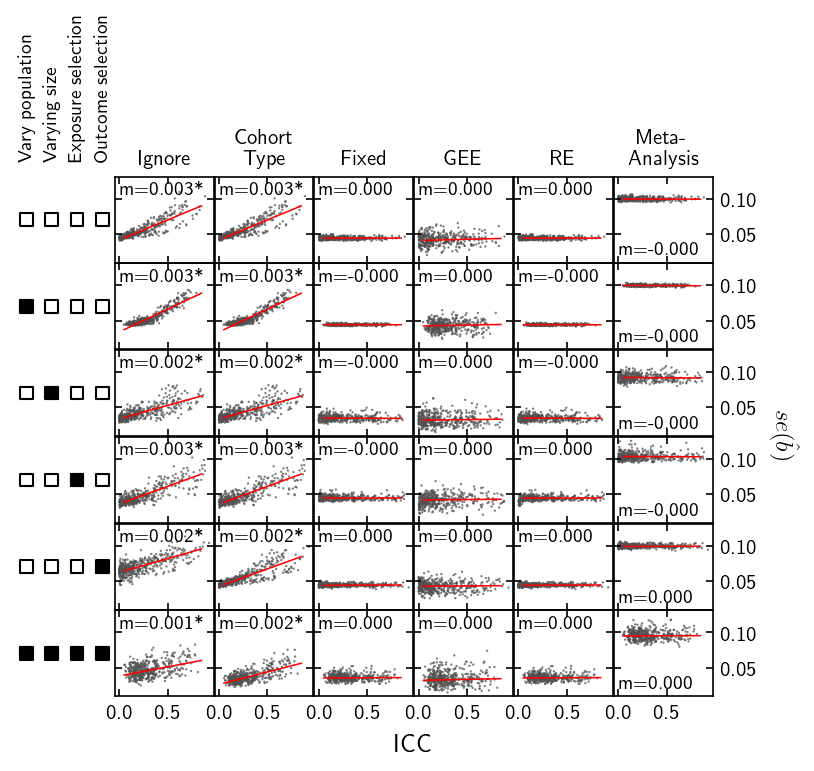

In [73]:
fig = plt.figure(dpi=150, constrained_layout=0, figsize=(6, 4.5))
gs = fig.add_gridspec(6, 7, wspace=0.01, hspace=0.01)

ax_ = None
axes = []
for i, scenario in enumerate(scenario_codes):
    ax_r = []
    for j, model in enumerate(tech_order):
        ax_ = _plot_corr_scatter(fig=fig, 
                                 gs=gs, 
                                 data=uniform_params, 
                                 i=i, scenario=scenario, 
                                 j=j, model=model, 
                                 y='bse', 
                                 # hue='sign_diff',
                                 # palette={-1: 'b', 1: 'r'},
                                 # palette='viridis',
                                 ax_ref=ax_)
        ax_.set_facecolor('None')
        ax_.xaxis.set_tick_params(labelbottom=(i == len(scenario_codes) - 1))
        ax_.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
        ax_.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.2f}'))
        ax_r.append(ax_)
    axes.append(ax_r)
    
predict_df = pd.DataFrame.from_dict(
    orient='columns',
    data={'icc2': np.linspace(0.05, 0.85, 25) / 0.05,
          'seed_effect': np.ones(25) * -0.1,
          }
)
    
    
bse_fits = dict()
for scenario, ax_r in zip(*(scenario_codes, axes)):
    for ax, model in zip(*(ax_r, tech_order)):
        # if not ((model == 'ignore') & (scenario == 0)):
            # continue
        m1 = _plot_regression_one_level(
            ax_=ax, 
            data=uniform_params, 
            scenario=scenario, 
            model=model, 
            predict_df=predict_df,
            formula='bse ~ icc2 + C(seed_effect)',
            # text_kws=dict(va='top'),
            ref_scale=0.05,
            line_kws=dict(color='r'),
            yscale=0.95 - 0.9 * (model in {'meta'}),
            text_kws=dict(va={'meta': 'bottom'}.get(model, 'top')),
            sig_alpha=0.05/35,
            )
        bse_fits[(scenario, model)] = m1
        
plot_ref_scatter(fig=fig, gs=gs, scenarios=scenarios_lo_var, check_mark='s')
        
ax_l = fig.add_subplot(gs[:, 1:], facecolor='None')
ax_l.set_ylabel('$se(\hat{b})$', size=12, rotation=-90, va='bottom', labelpad=42)
ax_l.yaxis.set_label_position('right')
ax_l.set_xlabel('ICC', size=12, labelpad=18)
ax_l.xaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)
ax_l.yaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)
sn.despine(ax=ax_l, left=True, right=True, top=True, bottom=True)

fig

**Figure**. Each row represents a different scenario, where one parameter is varied (the filled in squares indicate what has been changed). From top to bottom: All uniform cohorts, varying source population, varying cohort sizes, selecting cohrots on exposure, outcome enriched-cohorts, confounding by type (NICU cohrots have a different slope, but no difference in outcome), and finally, cohorts have a random slope for smoking as well as a random intercept. The data is modeled under six models (columns) and we extract the standard error for the estimate ($se(\hat{b}$) and compare to the ICC, a measure of cohort clustering. The scatter shows the estimated error for each simulation and model, the red line gives the fit relationship between ICC and error. The inset m shows the slope of this relationship.

<hr>

#### Modeling

In [74]:
model_rep = {
    m: a 
    for m, a in zip(*(['lme', 'ignore', 'risk', 'fixed', 'gee', 'meta'], 
                      list("ABCDEFGHIJKLM")))
    }
def compare_across_models_in_scenario(scenario, fit_prop):
    """
    Fits a model looking at the difference in models fits within a scenario
    """
    # Extracts the data an dcleans up to make modeling easier
    sub_scenario = uniform_params.xs(scenario, level='scenario').copy()
    sub_scenario = sub_scenario[sub_scenario['icc'] >= 0.05].copy()
    sub_scenario.reset_index(inplace=True)
    sub_scenario.replace({'model': model_rep}, inplace=True)
    
    # Fits the data
    fit_ = smf.mixedlm(f'{fit_prop} ~ model * icc + seed_effect', 
                       data=sub_scenario, 
                       groups=sub_scenario['unique_trial']
                       ).fit()
    
    # Pulls the parameters
    params = pd.concat(axis=1, objs=[fit_.params, fit_.bse, fit_.tvalues, 
                                     fit_.pvalues, fit_.conf_int().copy()])
    params.columns = ['param', 'bse', 't', 'p', 'ci_lo', 'ci_hi']
    
    params.drop(index=['Intercept', 'Group Var', 'seed_effect'], inplace=True)
    params['model'] = params.index.to_frame()[0].apply(
        lambda x: x.split(':')[0].split('[T.')[-1].replace(']', '')
        )
    params.replace({'model': {"icc": 'A'}}, inplace=True)
    params['icc'] = params.index.to_frame()[0].apply(lambda x: 'icc' in x) * 1
    params['scenario'] = scenario
    
    return params.reset_index(drop=True)

In [75]:
within_scenario = pd.concat(
    axis=0, 
    objs=[compare_across_models_in_scenario(scenario, 'bse') 
          for scenario in scenario_codes]
)
within_scenario.set_index(['scenario', 'icc', 'model'], inplace=True)
within_scenario['q'] = (within_scenario['p'] * len(scenario_codes))
within_scenario['q'] = within_scenario['q'].apply(lambda x: min(1, x))
within_scenario.replace({'q': {0: 1e-50}}, inplace=True)

within_scenario['log_q'] = np.ceil(-np.log10(within_scenario['q'])).astype(int) - \
    ((within_scenario['q'] > 0.05) & (within_scenario['q'] < 0.05)) * 1
within_scenario['q_text'] = within_scenario['log_q'].apply(
    lambda x: ''.join(['*'] * min(x, 3)))

In [76]:
wpar_bse_0 = within_scenario.xs(0, level='icc')['param'].unstack()
wval_bse_0 = within_scenario.xs(0, level='icc')['q_text'].unstack()
wpar_bse_0['A'] = 0
wval_bse_0['A'] = '(r)'
wpar_bse_0 = wpar_bse_0[['B', 'C', 'D',  'E', 'A', 'F']]
wval_bse_0 = wval_bse_0.loc[wpar_bse_0.index, wpar_bse_0.columns]

In [77]:
wpar_bse_1 = within_scenario.xs(1, level='icc')['param'].unstack()
wval_bse_1 = within_scenario.xs(1, level='icc')['q_text'].unstack()
wpar_bse_0['A'] = 0
wval_bse_0['A'] = '(r)'
wpar_bse_1 = wpar_bse_1[['B', 'C', 'D',  'E', 'A', 'F']]
wval_bse_1 = wval_bse_1.loc[wpar_bse_0.index, wpar_bse_0.columns]

### Accuracy

I'm also interested in the accuracy of the models, both absolute difference from the seed value and the error.

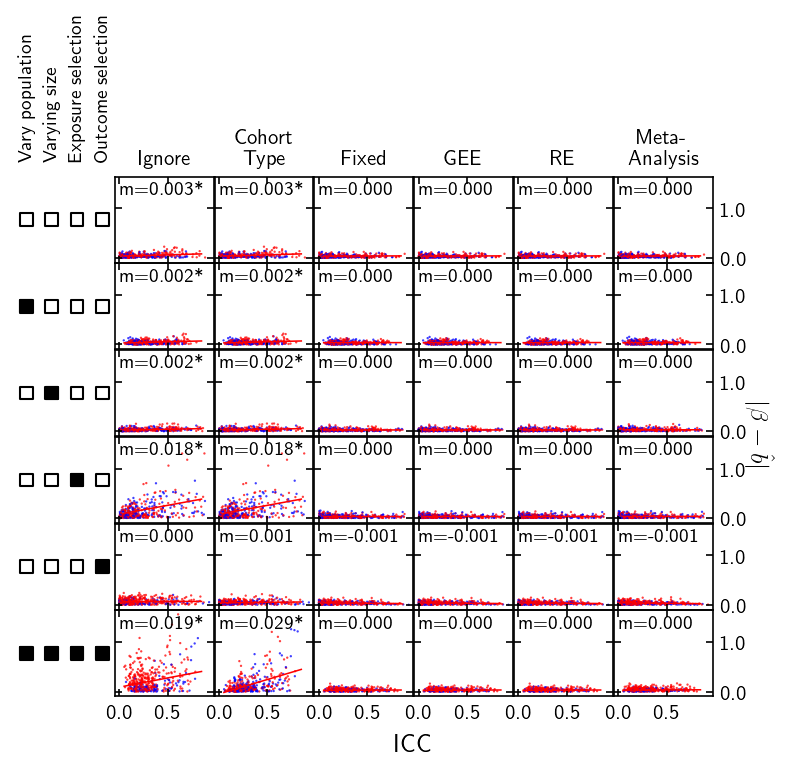

In [88]:
fig = plt.figure(dpi=150, constrained_layout=0, figsize=(6, 4.5))
gs = fig.add_gridspec(6, 7, wspace=0.01, hspace=0.01)

ax_ = None
axes = []
for i, scenario in enumerate(scenario_codes):
    ax_r = []
    for j, model in enumerate(tech_order):
        ax_ = _plot_corr_scatter(fig=fig, 
                                 gs=gs, 
                                 data=uniform_params, 
                                 i=i, scenario=scenario, 
                                 j=j, model=model, 
                                 # y='from_ref', 
                                 y='abs_diff',
                                 # hue='sign_diff',
                                 # palette={-1: 'b', 1: 'r'},
                                 # palette='viridis',
                                 ax_ref=ax_)
        ax_.set_facecolor('None')
        ax_.xaxis.set_tick_params(labelbottom=(i == len(scenario_codes) - 1))
        ax_.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
        ax_.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:1.1f}'))
        ax_r.append(ax_)
    axes.append(ax_r)
    
predict_df = pd.DataFrame.from_dict(
    orient='columns',
    data={'icc2': np.linspace(0.05, 0.85, 25) / 0.05,
          'seed_effect': np.ones(25) * -0.1,
          }
)
bse_fits = dict()
for scenario, ax_r in zip(*(scenario_codes, axes)):
    for ax, model in zip(*(ax_r, tech_order)):
        # if not ((model == 'ignore') & (scenario == 0)):
            # continue
        m1 = _plot_regression_one_level(
            ax_=ax, 
            data=uniform_params, 
            scenario=scenario, 
            model=model, 
            predict_df=predict_df,
            formula='abs_diff ~ icc2 + C(seed_effect)',
            # text_kws=dict(va='top'),
            ref_scale=0.05,
            line_kws=dict(color='r'),
            yscale=0.95,# - 0.9 * (model in {'meta'}),
            text_kws=dict(va={'meta': 'top'}.get(model, 'top')),
            sig_alpha=0.05/35,
            )
        bse_fits[(scenario, model)] = m1 
 
plot_ref_scatter(fig=fig, gs=gs, scenarios=scenarios_lo_var, check_mark='s')
        
ax_l = fig.add_subplot(gs[:, 1:], facecolor='None')
ax_l.set_ylabel('$| \\beta - \hat{b}|$', size=12, rotation=-90, va='bottom', labelpad=30)
ax_l.yaxis.set_label_position('right')
ax_l.set_xlabel('ICC', size=12, labelpad=18)
ax_l.xaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)
ax_l.yaxis.set_tick_params(bottom=False, labelbottom=False, top=False, labeltop=False, length=0, labelsize=0)
sn.despine(ax=ax_l, left=True, right=True, top=True, bottom=True)

# fig.savefig('/Users/jwd/Desktop/accuracy_no_reg.png', dpi=150, facecolor='w')
fig

**Figure**. Each row represents a different scenario, where one parameter is varied (the filled in squares indicate what has been changed). From top to bottom: All uniform cohorts, varying source population, varying cohort sizes, selecting cohorts on exposure, outcome enriched-cohorts, confounding by type (NICU cohrots have a different slope, but no difference in outcome), and finally, cohorts have a random slope for smoking as well as a random intercept. The data is modeled under six models (columns) and we extract the difference from the estimate and the original value ($|\beta_{seed} - \hat{b}|$) and compare to the ICC, a measure of cohort clustering. The scatter shows the difference for each model. Blue points are less than the original estimate, red points are greater than the estimate.

<hr>

We can look at the same plot, but allowing for sign varaition

In [89]:
within_scenario_acc = pd.concat(
    axis=0, 
    objs=[compare_across_models_in_scenario(scenario, 'abs_diff') 
          for scenario in scenario_codes]
)
within_scenario_acc.set_index(['scenario', 'icc', 'model'], inplace=True)
within_scenario_acc['q'] = (within_scenario_acc['p'] * len(scenario_codes))
within_scenario_acc['q'] = within_scenario_acc['q'].apply(lambda x: min(1, x))
within_scenario_acc.replace({'q': {0: 1e-50}}, inplace=True)

within_scenario_acc['log_q'] = \
    np.ceil(-np.log10(within_scenario_acc['q'])).astype(int) - \
    ((within_scenario_acc['q'] > 0.05) & (within_scenario_acc['q'] < 0.05)) * 1
within_scenario_acc['q_text'] = within_scenario_acc['log_q'].apply(
    lambda x: ''.join(['*'] * min(x, 3)))

In [90]:
wpar_acc_0 = within_scenario_acc.xs(0, level='icc')['param'].unstack()
wval_acc_0 = within_scenario_acc.xs(0, level='icc')['q_text'].unstack()
wpar_acc_0['A'] = 0
wval_acc_0['A'] = '(r)'
wpar_acc_0 = wpar_acc_0[['B', 'C', 'D',  'E', 'A', 'F']]
wval_acc_0 = wval_acc_0.loc[wpar_acc_0.index, wpar_acc_0.columns]

In [91]:
wpar_acc_1 = within_scenario_acc.xs(1, level='icc')['param'].unstack()
wval_acc_1 = within_scenario_acc.xs(1, level='icc')['q_text'].unstack()
wpar_acc_1 = wpar_acc_1[['B', 'C', 'D',  'E', 'A', 'F']]
wval_acc_1 = wval_acc_1.loc[wpar_acc_1.index, wpar_acc_1.columns]

## Summary

### Summary Figure

In [101]:
hm_kwargs = dict( fmt='s', annot_kws=dict(fontsize=7), linewidth=0.25, linecolor='k',)

def format_cbar(ax_cbar, label='', center=0):
    """
    Cleans up the colorbar axes
    """
    ax_cbar.set_yticks([ax_cbar.get_ylim()[0], 0, ax_cbar.get_ylim()[1]])
    ax_cbar.set_ylim(ax_cbar.get_ylim()[::-1])
    ax_cbar.set_yticklabels(['$\leftarrow$more', center, 'less$\\rightarrow$'],
                            rotation=-90)
    for l, orient in zip(*(ax_cbar.get_yticklabels(), ['top', 'center', 'bottom'])):
        l.set_va(orient)
        l.set_size(8)
    ax_cbar.set_ylabel(label, size=10, rotation=-90, labelpad=12)
    ax_cbar.yaxis.set_tick_params(right=False, length=0)

scenario_map = np.vstack([b for b, _ in scenarios_lo_var])
labelx = np.vstack([np.linspace(0, 1, 4)] * len(scenario_map))
labely = np.vstack([np.ones(4) * y + 0.5 for y in range(len(scenario_map))])
maskx = np.hstack((labelx + 0.1) * scenario_map)
maskx = maskx[maskx > 0] - 0.1
masky = np.hstack(labely * scenario_map)
masky = masky[masky > 0]

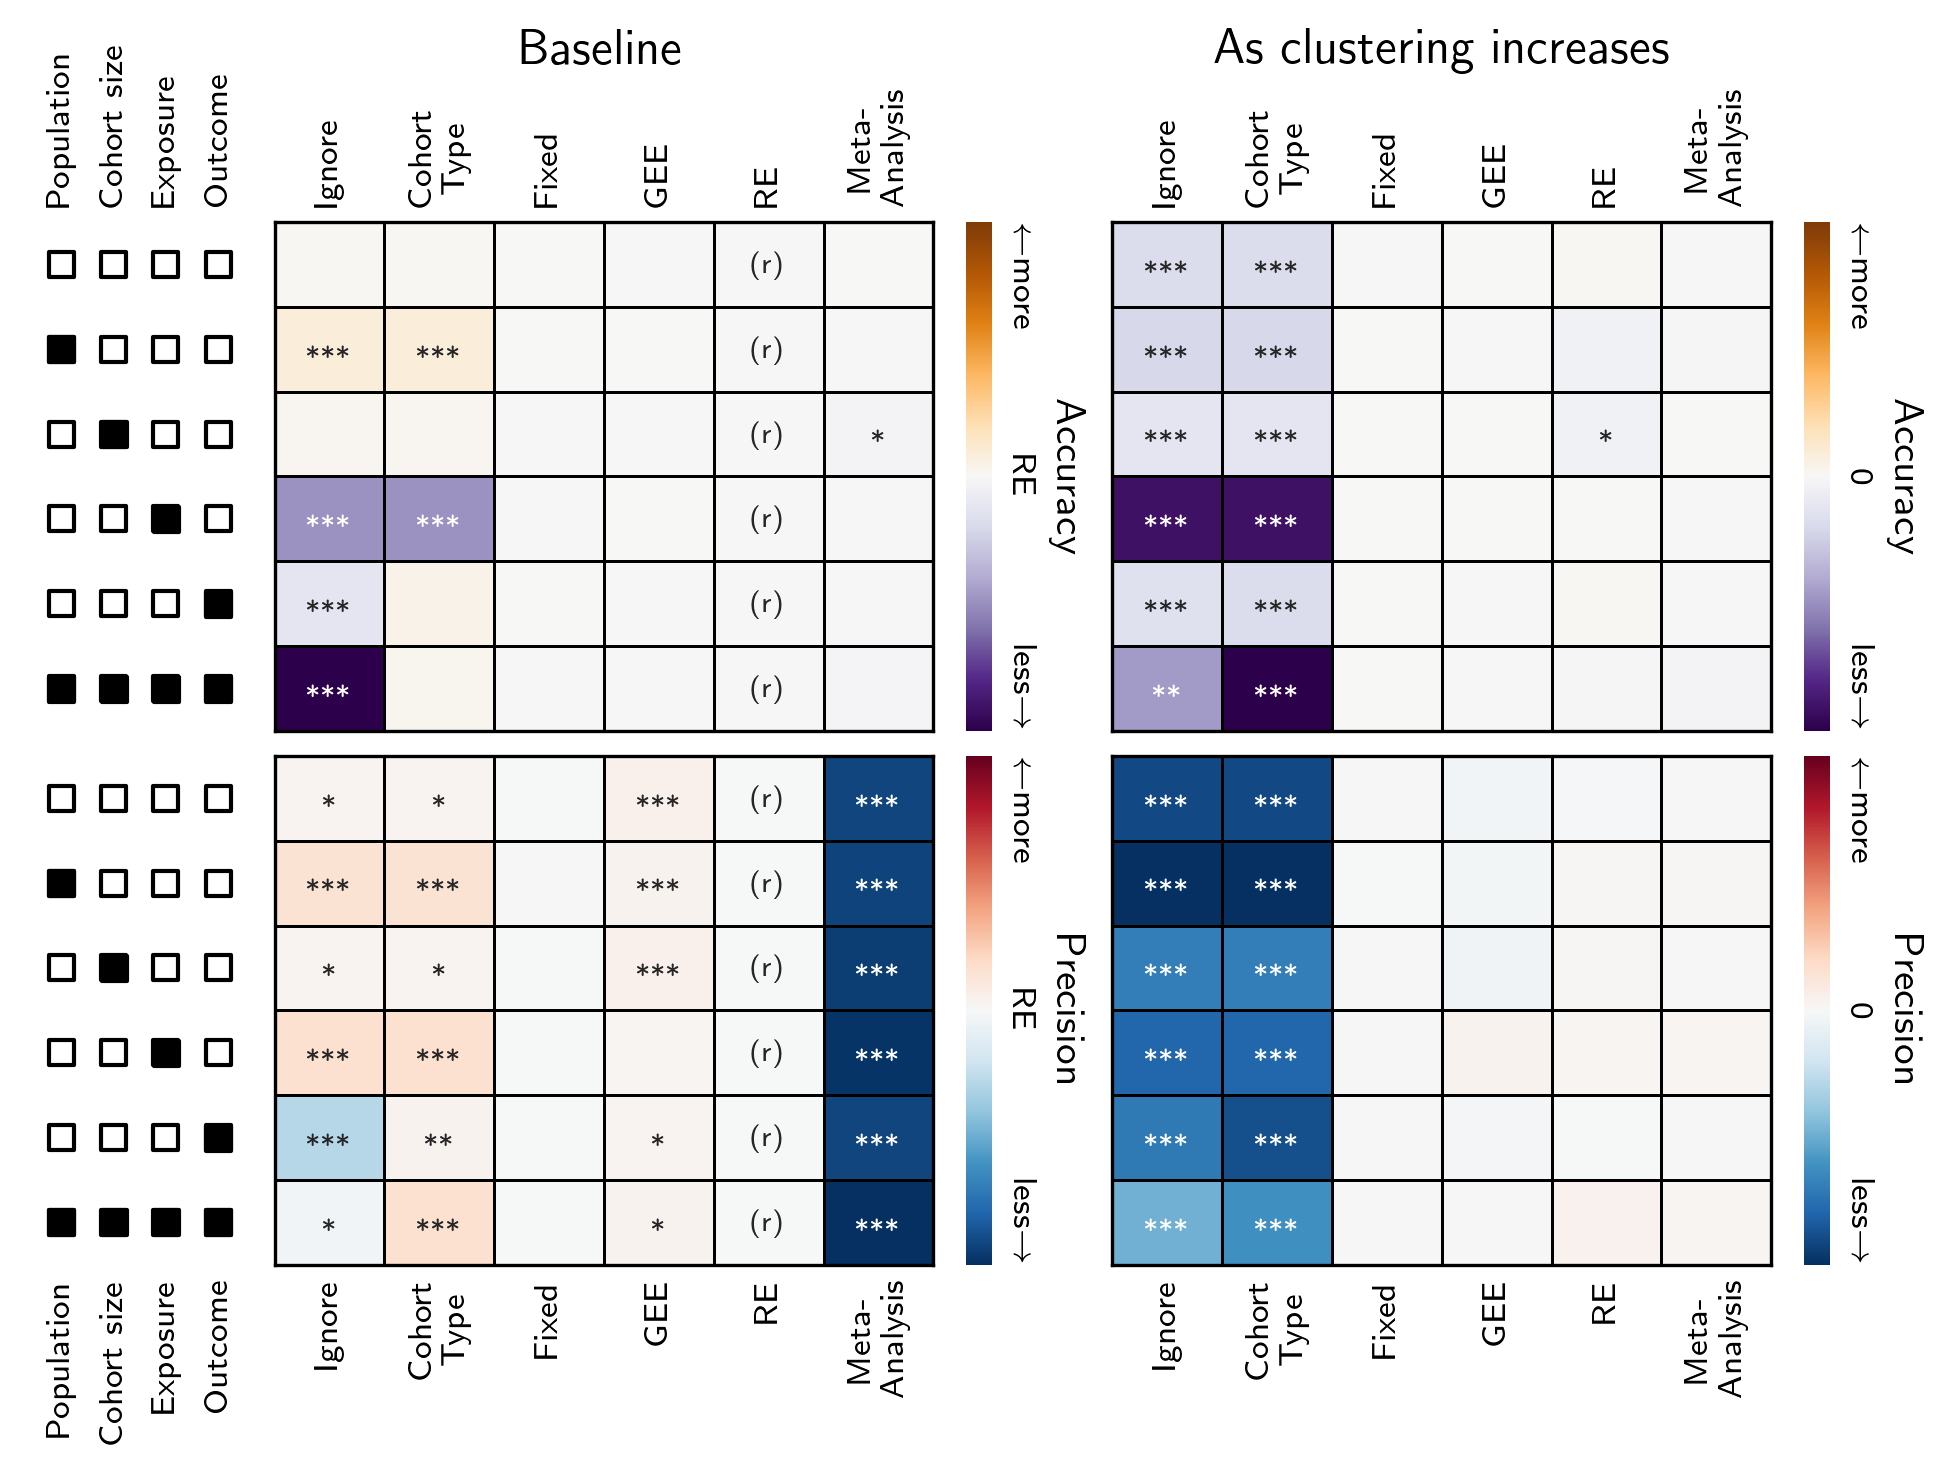

In [102]:
fig = plt.figure(dpi=300, constrained_layout=True)
gs = fig.add_gridspec(2, 7)

axla1 = fig.add_subplot(gs[1, 0])
axhm10 = fig.add_subplot(gs[1, 1:4], sharey=axla1)
axhm11 = fig.add_subplot(gs[1, 4:7], sharey=axla1)
axla0 = fig.add_subplot(gs[0, 0], sharex=axla1)
axhm00 = fig.add_subplot(gs[0, 1:4], sharey=axla0, sharex=axhm10)
axhm01 = fig.add_subplot(gs[0, 4:7], sharey=axla0, sharex=axhm11)

hm_data = [[wpar_bse_0, wval_bse_0, axhm10, 'Precision', 'RdBu', 'RE'],
           [wpar_bse_1, wval_bse_1, axhm11, 'Precision', 'RdBu', '0'],
           [wpar_acc_0, wval_acc_0, axhm00, 'Accuracy', 'PuOr', 'RE'],
           [wpar_acc_1, wval_acc_1, axhm01, 'Accuracy', 'PuOr', '0'],
          ]
for param, annot, ax, lab, cmap, center in hm_data:
    extreme = np.absolute(param).max().max()
    # Plots the heatmap
    sn.heatmap(data=param, 
               annot=annot,
               ax=ax,
               cmap=cmap,
               vmin=-extreme,
               vmax=extreme,
               **hm_kwargs,
              )
    # Tidies the x axis
    ax.set_xticklabels(
        [tidy_short.get(model, model.title()) for model in tech_order], 
        rotation=90, size=8)
    ax.xaxis.set_tick_params(bottom=False, top=False, length=0)
    ax.xaxis.get_label().set_visible(False)
    
    # Tidies the yaxis
    ax.yaxis.set_tick_params(left=False, labelleft=False,
                             right=False, labelright=False)
    ax.yaxis.get_label().set_visible(False)
    
    # Cleans up the colorbar
    format_cbar(fig.axes[-1], lab, center)
    sn.despine(ax=ax, left=False, right=False, top=False, bottom=False)



for ax in [axla1, axla0]:
    
    
    ax.scatter(np.hstack(labelx), np.hstack(labely), 
                  marker='s',
                  edgecolor='k',
                  facecolor='None',
                  )
    ax.scatter(np.hstack(maskx), np.hstack(masky), 
                  marker='s',
                  edgecolor='k',
                  facecolor='k',
                  )
    ax.set_xlim([-0.2, 1.2])
    ax.set_xticks(np.linspace(0, 1, 4))

    ax.yaxis.set_tick_params(left=False, labelleft=False)
    ax.set_xticklabels(['Population', 'Cohort size', 'Exposure', 'Outcome'], size=8, rotation=90)
    ax.xaxis.set_tick_params(bottom=False, top=False, length=0)
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)

for ax in [axla0, axhm00, axhm01]:
    ax.xaxis.set_tick_params(labelbottom=False, labeltop=True)
    
axhm00.set_title('Baseline')
axhm01.set_title('As clustering increases')

fig

I think the data shows the following three things:

1. The precision of models that ignore clustering decreases (the error increases) as the amount of cohort clustering increases. This is not seen in any other model that accounts for clustering.
2. Selection on exposure, rather than selection on outcome, affects the accuracy of models which ignore cohort effects, both the baseline accuracy and accuracy as a function of clustering. 
    * We should test this with filtering: does performance improve if we filter out cohorts that are exposed/unexposed
3. Mixing cohort types and not accounting for slope differences creates a bias, but doesn't substantially effect precision
4. Random slopes seem to affect GEE performance, but not any of the other models

# Low ICCs and Clustering

Amii and Emily were super interested in figuring out the threshhold below which ICC doesn't matter. The case where we selected on exposure had the largest effect on clustering, so I think we want to look at the effect of ICC on the relationships

In [103]:
worst_case = uniform_params.xs(4, level='scenario')
worst_case_lo = worst_case.loc[(worst_case['icc'] < 0.15) & (worst_case['icc'] > 0)].copy()
worst_case_lo_w = worst_case_lo.reset_index().pivot(
    index=['unique_trial', 'icc'],
    columns=['model'],
    values='from_ref',
)
worst_case_lo_w.dropna(inplace=True)
wc_from_lme = worst_case_lo_w - worst_case_lo_w[['lme']].values
wc_from_lme.reset_index(level='icc', inplace=True)
worst_case_lo_w.reset_index(level='icc', inplace=True)
wc_from_lme['icc_cat'] = wc_from_lme['icc'].apply(
    lambda x: np.sum([x > t for t in [0.01, 0.05, 0.1]]))
worst_case_lo_w['icc_cat'] = worst_case_lo_w['icc'].apply(
    lambda x: np.sum([x > t for t in [0.01, 0.05, 0.1]]))


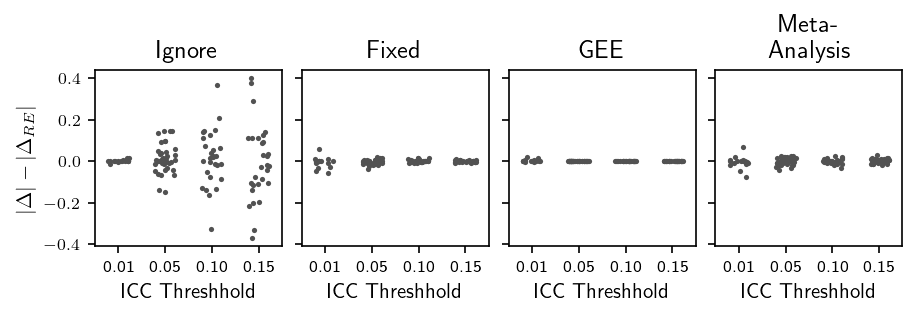

In [104]:
fig, axes = plt.subplots(1, 4, sharey=True,
                         dpi=150, constrained_layout=True, figsize=(6, 2))
for i, (ax0, tech) in enumerate(zip(*(axes, ['ignore', 'fixed', 'gee', 'meta']))):
    sn.stripplot(x='icc_cat', y=tech, data=wc_from_lme, 
                 marker='.', s=5, jitter=0.225, color='#525252',
                 ax=ax0)
    ax0.set_ylabel('$|\\Delta| - |\\Delta_{RE}|$')
    ax0.yaxis.get_label().set_visible(i == 0)
    ax0.yaxis.set_tick_params(left=True, labelleft=(i == 0), labelsize=8)
    ax0.set_xticks(np.arange(4))
    ax0.set_xticklabels(['0.01', '0.05', '0.10', '0.15'],
                       size=8)
    ax0.set_xlabel('ICC Threshhold')
    ax0.set_title(tidy_short.get(tech, tech.title()))

fig

# Filtering

In [105]:
%%capture

fit_eq = 'm_age + year + C(race) + C(sex) + C(ethnicity)'
filtering_res = dict()
sim_count = 0
_, seed_kwargs = scenarios_lo_var[-1]
for effect, (icc, var) in it.product(effects, seed_var.items()):
    filtering_res[(effect, icc)] = []
    for i in range(num_sim):
        # Simulates the data
        sim_seeds = build_sim_params(**seed_kwargs, num_cohorts=20)
        data, _ = bw_sim.simulate_cohort(**sim_seeds,
                                          betas=slopes,
                                          icc=var,
                                          smoking_effect=effect,
                                          exposure_demo_mod=smoking_effect,
                                          rescale=False,
                                          )
        # Caclulates the ICC and the general cohort ICC
        fit = smf.mixedlm('y ~ 1', data=data, groups=data['cohort']).fit()
        fit_icc = bw_ana.icc_from_lme(fit)
        if (icc >= 1) | (icc < 0) | np.any(np.trace(fit.cov_params()) < 0):
            fit_icc = 0
        if len(data['cohort_type'].unique()) > 1:
            data2 = data.loc[data['cohort_type'].isin(['0', 0])].copy()
            fit2 = smf.mixedlm('y ~ 1', 
                               data=data2, 
                               groups=data2['cohort']).fit()
            fit_icc2 = bw_ana.icc_from_lme(fit2)
            if (fit_icc2 >= 1) | (fit_icc2 < 0) | np.any(np.trace(fit2.cov_params()) < 0):
                fit_icc2 = 0
        else:
            fit_icc2 = fit_icc
         # Filts the data and model
        model_adj = {
            (name, fname): model(fit_icc2, f_(data), fit_eq) 
            for (name, model) in zip(*(tech_order, models))
            for (fname, f_) in filters.items()
            }
        summary = {'data': data, 
                   'fit_icc': fit_icc2,
                   'adj': model_adj,
                   'id_': sim_count
                   }
        filtering_res[(effect, icc)].append(summary)
        
        sim_count += 1


In [106]:
extracted_params = pd.DataFrame.from_dict(
    data={(15, eff, seed_icc, i, name, filt_, adj, icc, conv * 1, ds['id_']): params
          for (seed_icc, eff), eff_combo in filtering_res.items()
          for i, ds in enumerate(eff_combo)
          for adj in ['adj']
          for (model, filt_), (icc, fit_, params, conv, name) in ds[adj].items()
          },
    orient='index',
)
extracted_params.index.set_names(['scenario', 'seed_icc', 'seed_effect', 
                                  'iter', 'model', 'filter', 'adjustment', 
                                  'icc', 'converged', 'trial'],
                                 inplace=True)
extracted_params.reset_index(level='adjustment', inplace=True, drop=True)

In [120]:
filt_study = extracted_params.loc[extracted_params.reset_index()[['converged', 'model']].isin([1, 'meta']).any(axis=1).values].copy()
filt_study.reset_index(inplace=True)
filt_study['sig'] = ((filt_study['p-value'] < 0.05) | 
                     (filt_study['p-value'].isna() & (np.sign(filt_study['ci_lo']) == np.sign(filt_study['ci_hi'])))) * 1
filt_study['incl'] = ((filt_study['ci_lo'] <= filt_study['seed_effect']) &
                      (filt_study['ci_hi'] >= filt_study['seed_effect'])) * 1
filt_study.groupby(['scenario', 'seed_effect', 'model', 'filter'])['sig'].mean().unstack(-2).round(3)

model                         fixed    gee  ignore    lme  meta   risk
scenario seed_effect filter                                           
15       -0.5        all      1.000  1.000   0.985  1.000   1.0  0.985
                     general  1.000  1.000   0.985  1.000   1.0  0.985
                     none     1.000  1.000   0.956  1.000   1.0  0.985
                     only     1.000  1.000   0.978  1.000   1.0  0.993
                     other    1.000  1.000   0.956  1.000   1.0  0.985
                     small    1.000  1.000   0.956  1.000   1.0  0.985
         -0.1        all      0.726  0.791   0.652  0.717   0.0  0.652
                     general  0.748  0.813   0.696  0.766   0.0  0.696
                     none     0.800  0.837   0.570  0.785   0.0  0.741
                     only     0.800  0.844   0.452  0.793   0.0  0.659
                     other    0.800  0.837   0.578  0.785   0.0  0.741
                     small    0.807  0.822   0.585  0.793   0.0  0.719

In [107]:
filt_study2 = extracted_params.loc[extracted_params.reset_index()[['converged', 'model']].isin([1, 'meta']).any(axis=1).values].copy()
filt_study2.reset_index(level=['seed_effect', 'icc', 'trial'], inplace=True)
filt_study2['from_ref'] = filt_study2['param'] - filt_study2['seed_effect']
filt_study2['abs_diff'] = np.absolute(filt_study2['from_ref'])
filt_study2['sign'] = np.sign(filt_study2['from_ref'])

In [108]:
error_wide = filt_study2.reset_index().pivot(
    index=['scenario', 'seed_icc', 'seed_effect', 'model', 'trial'],
    columns='filter',
    values='bse'
)
error_wide2 = np.log2(error_wide.div(error_wide['none'], axis=0))

In [109]:
acc_wide = filt_study2.reset_index().pivot(
    index=['scenario', 'seed_icc', 'seed_effect', 'model', 'trial'],
    columns='filter',
    values='abs_diff'
)
acc_wide2 = (acc_wide - acc_wide[['none']].values)

In [110]:
long_acc = acc_wide2.reset_index().melt(
    id_vars=['scenario', 'seed_icc', 'seed_effect', 'model', 'trial']
)
long_acc['filter'] = pd.Categorical(long_acc['filter'], list(filters.keys()), ordered=True)
long_acc.set_index(['scenario', 'seed_icc', 'seed_effect', 'model', 'trial'], 
                    inplace=True)

In [111]:
long_err = error_wide2.reset_index().melt(
    id_vars=['scenario', 'seed_icc', 'seed_effect', 'model', 'trial']
)
long_err['filter'] = pd.Categorical(long_err['filter'], list(filters.keys()), 
                                    ordered=True)
long_err.set_index(['scenario', 'seed_icc', 'seed_effect', 'model', 'trial'], 
                    inplace=True)

In [87]:
def _fit_extract(data_, filter_order):
    """
    Fits a long fitler model and gets the parameters
    """
    data_['filter'] = data_['filter'].astype(str)
    data_.replace({'filter': {v: str(i) for i, v in enumerate(filter_order)}},
                  inplace=True)
    data_['filter'] = data_['filter'].astype(int)
    fit_ = smf.mixedlm('value ~ C(filter)',
                       data=data_.reset_index(),
                       groups=data_.reset_index()['trial']
                       ).fit()
    df = pd.DataFrame({
        'param': fit_.params.drop(['Group Var']),
        'width': (fit_.conf_int()[1] - fit_.params).drop(['Group Var']),
        'pvalue': fit_.pvalues.drop(['Group Var'])
        })
    df.loc['Intercept', ['param', 'width', 'pvalue']] = [0, np.nan, 1]
    df['x'] = np.arange(len(df))
    df['filter'] = filter_order
    df.reset_index(drop=True, inplace=True)
    return df

_fit_extract(long_acc.xs(model, level='model').copy().dropna(), 
             filter_order)

,param,width,pvalue,x,filter
0,0.000000e+00,NaN,1.000000,0,none
1,-5.707061e-04,0.002542,0.659860,1,small
2,8.789440e-18,0.002542,1.000000,2,only
3,-1.254930e-03,0.002542,0.333167,3,general
4,-1.711745e-03,0.002542,0.186824,4,all
5,-2.561154e-04,0.002542,0.843431,5,other


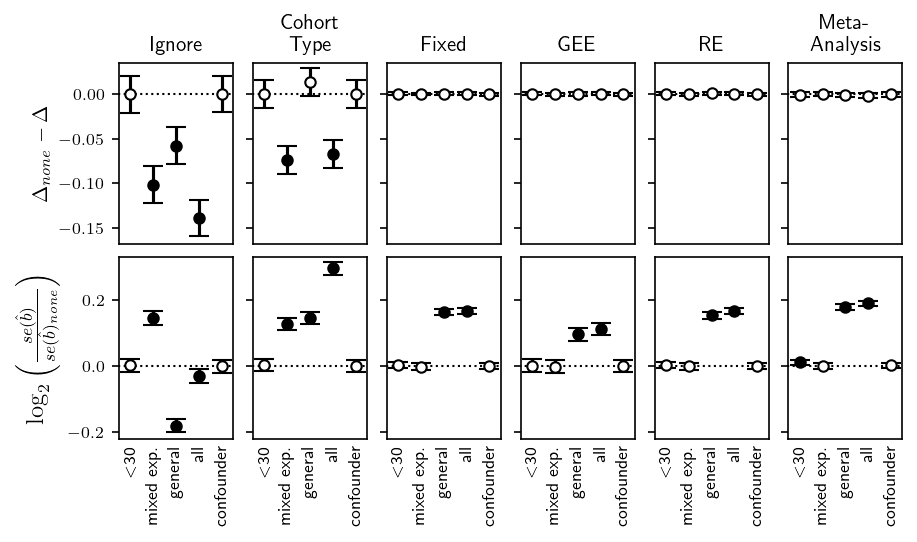

In [88]:
error_kwargs = dict(linestyle='', marker='o', capsize=5, color='k', markersize=5, zorder=2)
fig, axes = plt.subplots(2, 6, 
                         sharex=True,
                         dpi=150,
                         constrained_layout=True, 
                         figsize=(6, 3.5))

for i, (axr, ref_df) in enumerate(zip(*(axes, [long_acc, long_err]))):
    ylim = []
    for ax, model in zip(*(axr, tech_order)):
        data_ = ref_df.xs(model, level='model').copy().dropna()
        fit_df = _fit_extract(data_, filter_order).drop([0])
        ax.errorbar(x='x', y='param', yerr='width',
                    data=fit_df.loc[fit_df['pvalue'] >= 0.05],
                    markerfacecolor='w',
                    **error_kwargs)
        ax.errorbar(x='x', y='param', yerr='width',
                    data=fit_df.loc[fit_df['pvalue'] < 0.05],
                    **error_kwargs)

        ylim.append(ax.get_ylim())
        ax.set_xticks(fit_df['x'])
        ax.set_xticklabels(['$<$30', 'mixed exp.', 'general', 'all', 'confounder'], 
                           rotation=90, size=8)
        ax.plot([-1, 10], [0, 0], 'k:', linewidth=1)
        ax.set_xlim(fit_df['x'].min() - 0.5, fit_df['x'].max() + 0.5)
        ax.xaxis.set_tick_params(bottom=False, labelbottom=(i == 1), 
                                 labelsize=8, length=0)
        if i == 0:
            ax.set_title(tidy_short.get(model, model.title()), size=10)

    ymost = [np.hstack(ylim).min(), np.hstack(ylim).max()]
    for i, ax in enumerate(axr):
        ax.set_ylim(ymost)
        ax.yaxis.set_tick_params(left=True, labelleft=(i == 0), labelsize=8)

axes[0][0].set_ylabel('$\Delta_{none} - \Delta$')
axes[1][0].set_ylabel(
    '$\log_{2} \\left ( \\frac{se(\hat{b})}{se(\hat{b})_{{none}}} \\right )$', 
    size=12)
fig